# Installations & Imports

In [ ]:
! pip install shap
! pip install missingno
! pip install catboost

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import shap
from sklearn.manifold import Isomap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
import missingno
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pandas.api.types import is_numeric_dtype


SEED = 41
np.random.seed(SEED)

Mounted at /content/MyDrive


#Load data

In [3]:
training_data_path = "/content/MyDrive/Shareddrives/medical predictions project/training_v2.csv"
train_df = pd.read_csv(training_data_path, index_col='encounter_id')

description_data_path = "/content/MyDrive/Shareddrives/medical predictions project/WiDS Datathon 2020 Dictionary.csv"
description_df = pd.read_csv(description_data_path)

pd.set_option("max_columns", 185)
train_df.head(10)

patient_id  hospital_id  hospital_death   age    bmi  \
encounter_id                                                         
66154              25312          118               0  68.0  22.73   
114252             59342           81               0  77.0  27.42   
119783             50777          118               0  25.0  31.95   
79267              46918          118               0  81.0  22.64   
92056              34377           33               0  19.0    NaN   
33181              74489           83               0  67.0  27.56   
82208              49526           83               0  59.0  57.45   
120995             50129           33               0  70.0    NaN   
80471              10577          118               1  45.0    NaN   
42871              90749          118               0  50.0  25.71   

              elective_surgery  ethnicity gender  height  \
encounter_id                                               
66154                        0  Caucasian      M   180.3   
114252                       0  Caucasian      F   160.0   
119783                       0  Caucasian      F   172.7   
79267                        1  Caucasian      F   165.1   
92056                        0  Caucasian      M   188.0   
33181                        0  Caucasian      M   190.5   
82208                        0  Caucasian      F   165.1   
120995                       0  Caucasian      M   165.0   
80471                        0  Caucasian      M   170.2   
42871                        0        NaN      M   175.3   

             hospital_admit_source           icu_admit_source  icu_id  \
encounter_id                                                            
66154                        Floor                      Floor      92   
114252                       Floor                      Floor      90   
119783        Emergency Department       Accident & Emergency      93   
79267               Operating Room  Operating Room / Recovery      92   
92056                          NaN       Accident & Emergency      91   
33181                 Direct Admit       Accident & Emergency      95   
82208               Operating Room       Accident & Emergency      95   
120995        Emergency Department       Accident & Emergency      91   
80471               Other Hospital             Other Hospital     114   
42871                 Direct Admit       Accident & Emergency     114   

             icu_stay_type      icu_type  pre_icu_los_days  \
encounter_id                                                 
66154                admit         CTICU          0.541667   
114252               admit  Med-Surg ICU          0.927778   
119783               admit  Med-Surg ICU          0.000694   
79267                admit         CTICU          0.000694   
92056                admit  Med-Surg ICU          0.073611   
33181                admit  Med-Surg ICU          0.000694   
82208                admit  Med-Surg ICU          0.000694   
120995               admit  Med-Surg ICU          0.002083   
80471                admit     CCU-CTICU          0.009028   
42871                admit     CCU-CTICU          0.060417   

              readmission_status  weight  albumin_apache  apache_2_diagnosis  \
encounter_id                                                                   
66154                          0    73.9             2.3               113.0   
114252                         0    70.2             NaN               108.0   
119783                         0    95.3             NaN               122.0   
79267                          0    61.7             NaN               203.0   
92056                          0     NaN             NaN               119.0   
33181                          0   100.0             NaN               301.0   
82208                          0   156.6             NaN               108.0   
120995                         0     NaN             NaN               113.0   
80471                         

# Data exploration 

### **Features description**

###### Distribution of predictive column

The number of hospital live records(0): 83798(91.37%)
The number of hospital death records(1): 7915(8.63%)
 


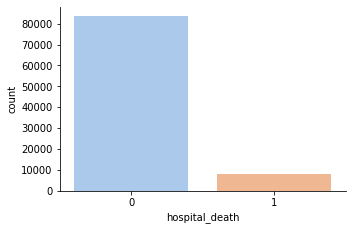

In [ ]:
# The distribution of live and death labels

predictive_col = train_df['hospital_death']
n_death = len(predictive_col[predictive_col == 1])
n_live = len(predictive_col[predictive_col == 0])

print(f"The number of hospital live records(0): {n_live}({round(n_live/len(predictive_col) * 100, 2)}%)")
print(f"The number of hospital death records(1): {n_death}({round(n_death/len(predictive_col) * 100, 2)}%)")
print(" ")

sns.catplot(x ='hospital_death', kind ='count', palette="pastel", data = train_df)
plt.gcf().set_size_inches(5, 3)

###### Distribution of interesting features

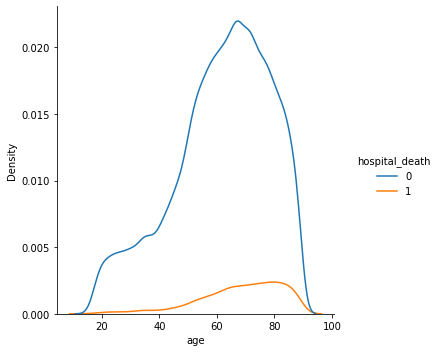

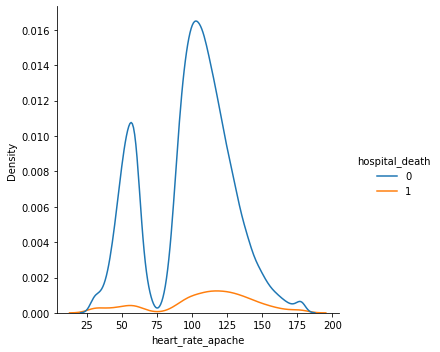

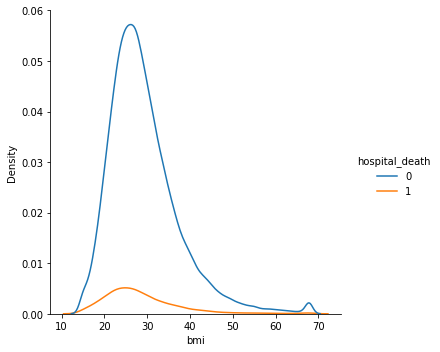

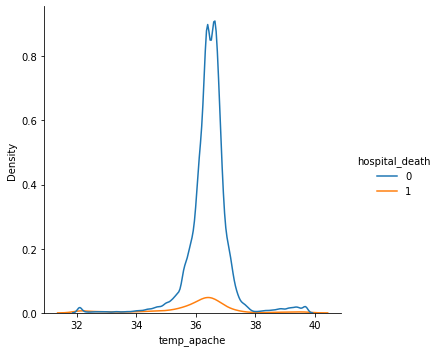

In [4]:
def plot_feature_distribution(data, feature_name, target):
    sns.displot(data, x=feature_name, hue=target, kind="kde")
    plt.show()

plot_feature_distribution(train_df, "age", "hospital_death")
plot_feature_distribution(train_df, "heart_rate_apache", "hospital_death")
plot_feature_distribution(train_df, "bmi", "hospital_death")
plot_feature_distribution(train_df, "temp_apache", "hospital_death")

###### columns description

In [ ]:
pd.set_option('max_rows', 188)
description_df = description_df[['Variable Name', 'Data Type', 'Description']]
description_df

Variable Name Data Type  \
0                     encounter_id   integer   
1                      hospital_id   integer   
2                       patient_id   integer   
3                   hospital_death    binary   
4                              age   numeric   
5                              bmi    string   
6                 elective_surgery    binary   
7                        ethnicity    string   
8                           gender    string   
9                           height   numeric   
10           hospital_admit_source    string   
11                icu_admit_source    string   
12                  icu_admit_type    string   
13                          icu_id   integer   
14                   icu_stay_type    string   
15                        icu_type    string   
16                pre_icu_los_days   numeric   
17              readmission_status    binary   
18                          weight   numeric   
19                  albumin_apache   numeric   
20              apache_2_diagnosis    string   
21             apache_3j_diagnosis    string   
22           apache_post_operative    binary   
23                      arf_apache    binary   
24                bilirubin_apache   numeric   
25                      bun_apache   numeric   
26               creatinine_apache   numeric   
27                     fio2_apache   numeric   
28                 gcs_eyes_apache   integer   
29                gcs_motor_apache   integer   
30               gcs_unable_apache    binary   
31               gcs_verbal_apache   integer   
32                  glucose_apache   numeric   
33               heart_rate_apache   numeric   
34               hematocrit_apache   numeric   
35                intubated_apache    binary   
36                      map_apache   numeric   
37                    paco2_apache   numeric   
38             paco2_for_ph_apache   numeric   
39                     pao2_apache   numeric   
40                       ph_apache   numeric   
41                 resprate_apache   numeric   
42                   sodium_apache   numeric   
43                     temp_apache   numeric   
44              urineoutput_apache   numeric   
45               ventilated_apache    binary   
46                      wbc_apache   numeric   
47          d1_diasbp_invasive_max   numeric   
48          d1_diasbp_invasive_min   numeric   
49                   d1_diasbp_max   numeric   
50                   d1_diasbp_min   numeric   
51       d1_diasbp_noninvasive_max   numeric   
52       d1_diasbp_noninvasive_min   numeric   
53                d1_heartrate_max   numeric   
54                d1_heartrate_min   numeric   
55             d1_mbp_invasive_max   numeric   
56             d1_mbp_invasive_min   numeric   
57                      d1_mbp_max   numeric   
58                      d1_mbp_min   numeric   
59          d1_mbp_noninvasive_max   numeric   
60          d1_mbp_noninvasive_min   numeric   
61                 d1_resprate_max   numeric   
62                 d1_resprate_min   numeric   
63                     d1_spo2_max   numeric   
64                     d1_spo2_min   numeric   
65           d1_sysbp_invasive_max   numeric   
66           d1_sysbp_invasive_min   numeric   
67                    d1_sysbp_max   numeric   
68                    d1_sysbp_min   numeric   
69        d1_sysbp_noninvasive_max   numeric   
70        d1_sysbp_noninvasive_min   numeric   
71                     d1_temp_max   numeric   
72                     d1_temp_min   numeric   
73          h1_diasbp_invasive_max   numeric   
74          h1_diasbp_invasive_min   numeric   
75                   h1_diasbp_max   numeric   
76                   h1_diasbp_min   numeric   
77       h1_diasbp_noninvasive_max   numeric   
78       h1_diasbp_noninvasive_min   numeric   
79                h1_heartrate_max   numeric   
80                h1_heartrate_min   numeric   
81             h1_mbp_invasive_max   numeric   
82             h1_mbp_invasive_min   

In [ ]:
pd.set_option("max_rows", 10)
train_df.describe().T

count          mean           std        min  \
patient_id                   91713.0  65537.131464  37811.252183   1.000000   
hospital_id                  91713.0    105.669262     62.854406   2.000000   
hospital_death               91713.0      0.086302      0.280811   0.000000   
age                          87485.0     62.309516     16.775119  16.000000   
bmi                          88284.0     29.185818      8.275142  14.844926   
...                              ...           ...           ...        ...   
hepatic_failure              90998.0      0.012989      0.113229   0.000000   
immunosuppression            90998.0      0.026165      0.159628   0.000000   
leukemia                     90998.0      0.007066      0.083763   0.000000   
lymphoma                     90998.0      0.004132      0.064148   0.000000   
solid_tumor_with_metastasis  90998.0      0.020638      0.142169   0.000000   

                                      25%           50%           75%  \
patient_id                   32830.000000  65413.000000  98298.000000   
hospital_id                     47.000000    109.000000    161.000000   
hospital_death                   0.000000      0.000000      0.000000   
age                             52.000000     65.000000     75.000000   
bmi                             23.641975     27.654655     32.930206   
...                                   ...           ...           ...   
hepatic_failure                  0.000000      0.000000      0.000000   
immunosuppression                0.000000      0.000000      0.000000   
leukemia                         0.000000      0.000000      0.000000   
lymphoma                         0.000000      0.000000      0.000000   
solid_tumor_with_metastasis      0.000000      0.000000      0.000000   

                                      max  
patient_id                   131051.00000  
hospital_id                     204.00000  
hospital_death                    1.00000  
age                              89.00000  
bmi                              67.81499  
...                                   ...  
hepatic_failure                   1.00000  
immunosuppression                 1.00000  
leukemia                          1.00000  
lymphoma                          1.00000  
solid_tumor_with_metastasis       1.00000  

[177 rows x 8 columns]

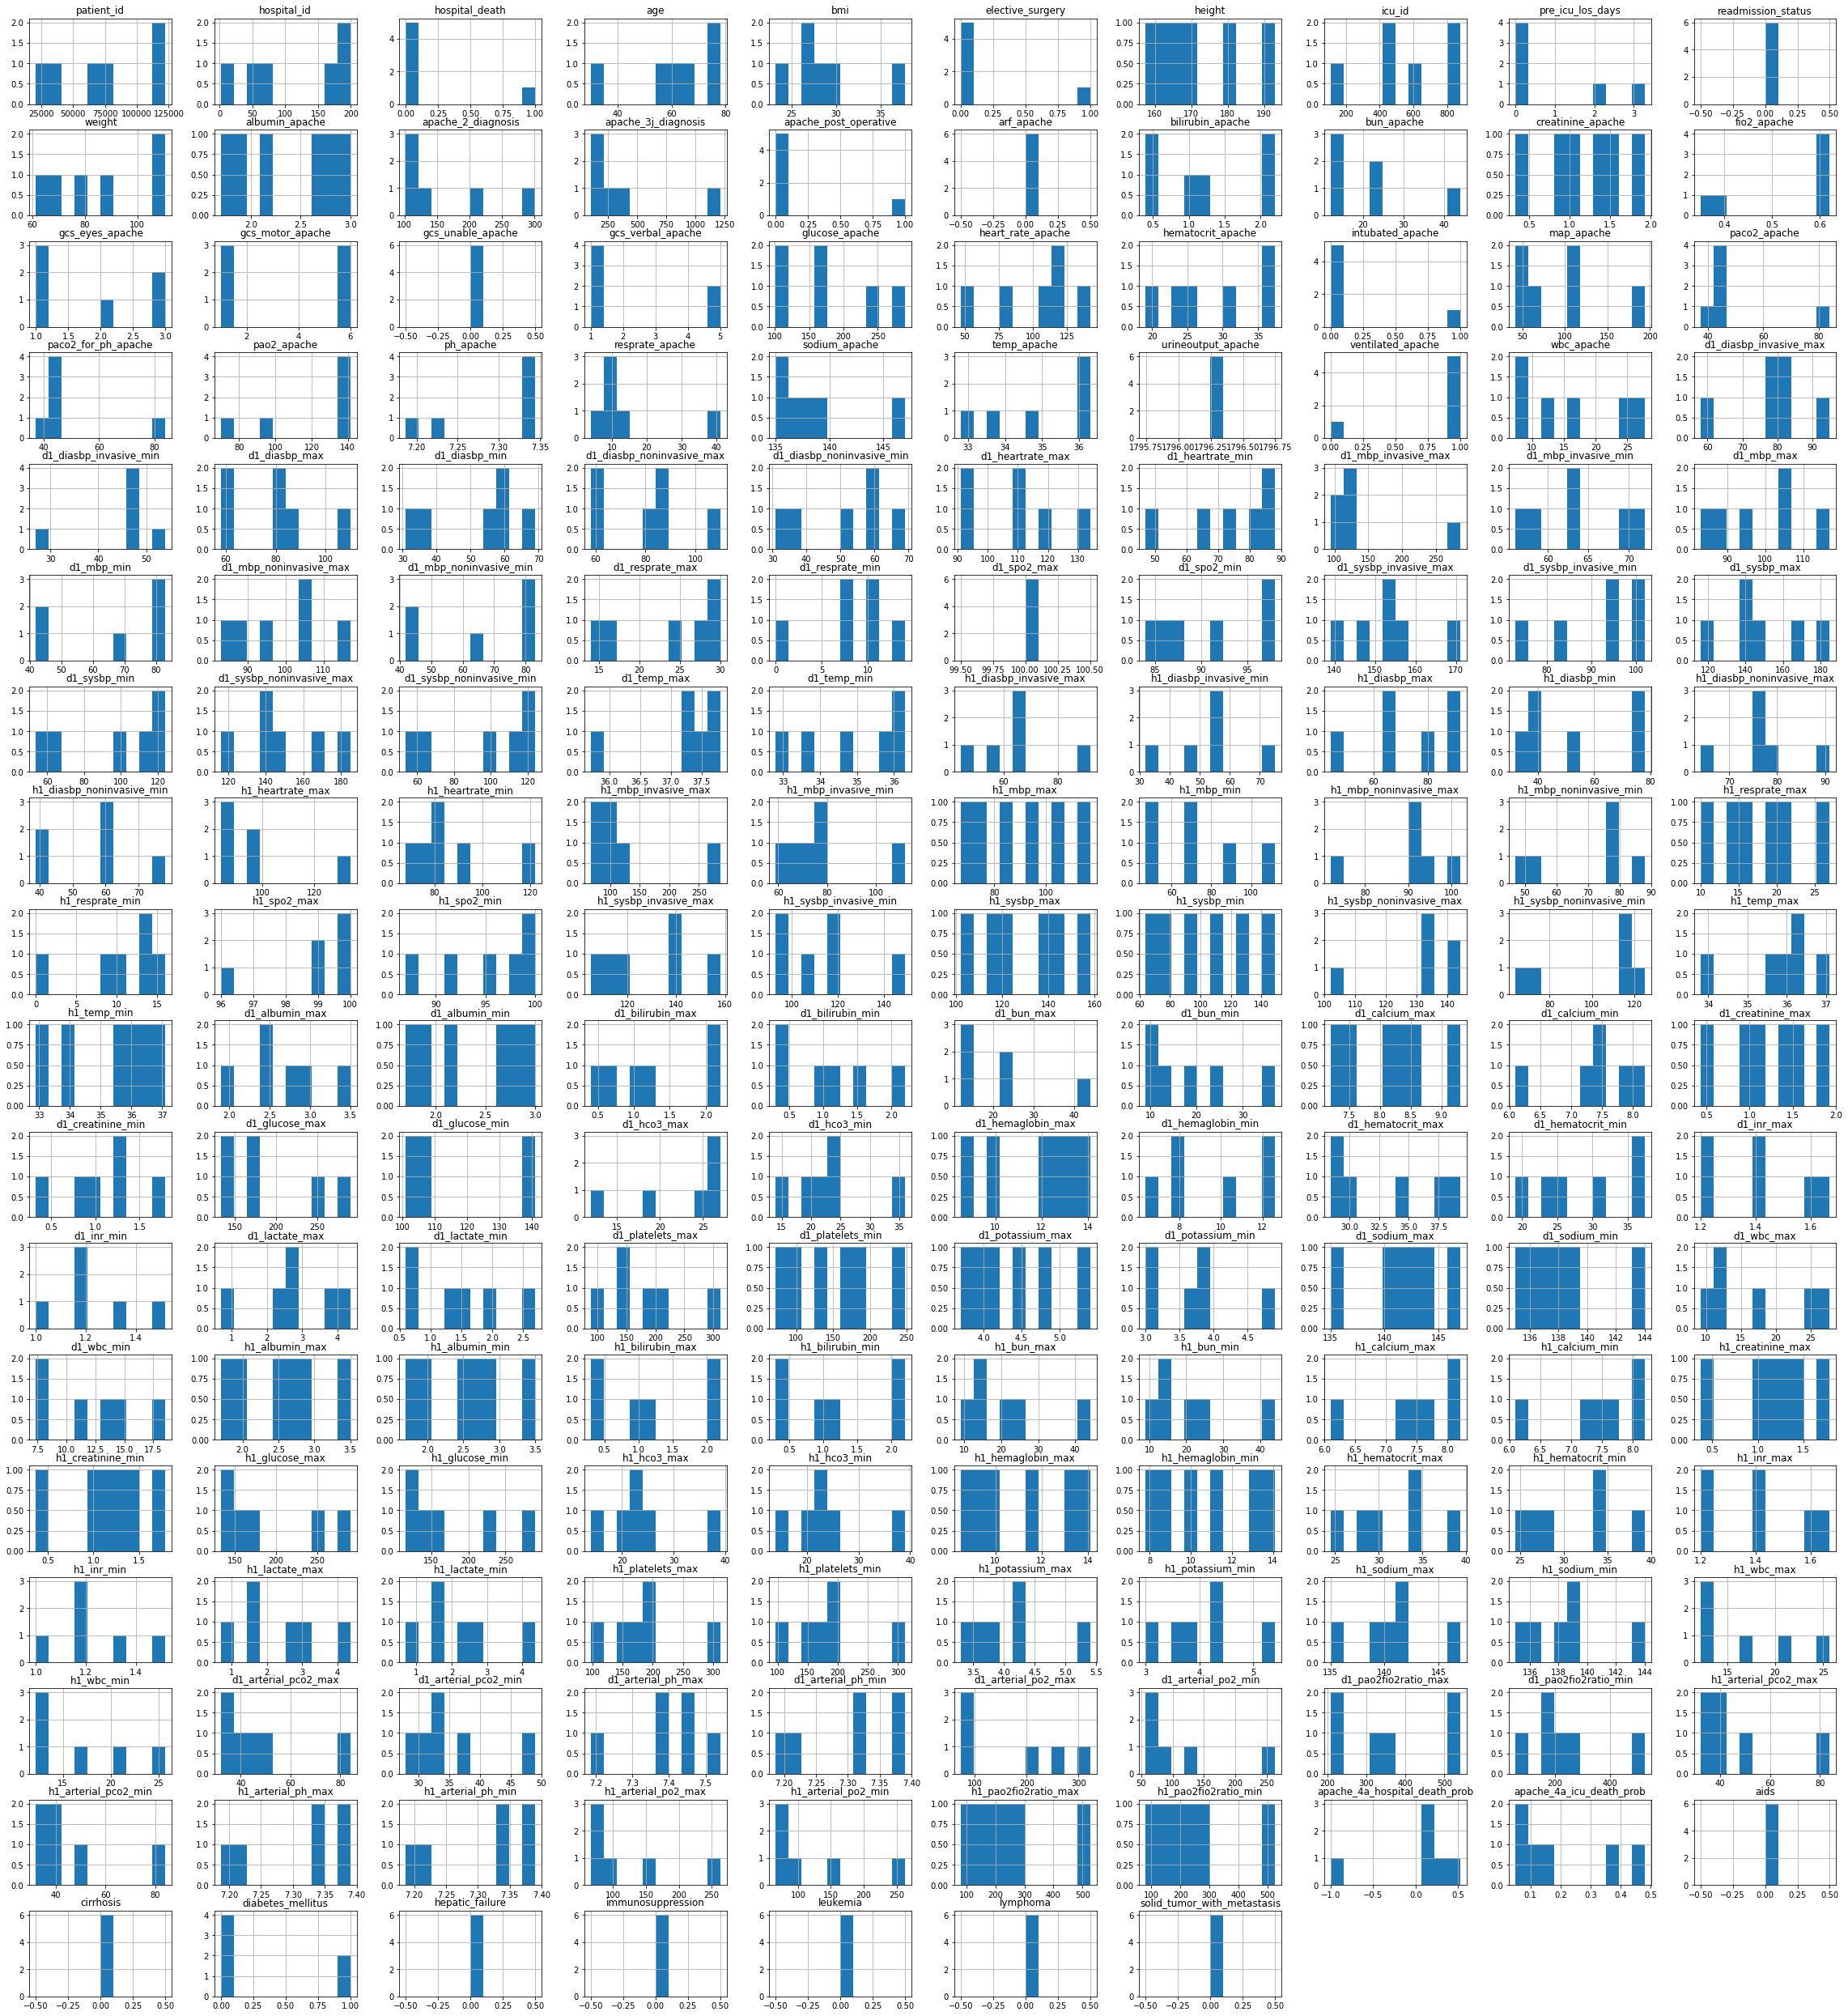

In [ ]:
train_df.dropna().hist(figsize=(40,50), layout=(20,10))
plt.show()

### **Missing values analasis**

##### Missing values per feature

In [ ]:
# Get the number of missing values for each feature
pd.set_option('max_row', 185)
nan_values_per_feature = train_df.isna().sum()
nan_values_per_feature_pct  = nan_values_per_feature.sort_values(ascending=False)/train_df.shape[0]
print(f"Missing values for each feature:\n\n{nan_values_per_feature.sort_values(ascending=False)/  train_df.shape[0]}")

Missing values for each feature:

h1_bilirubin_min                 0.922650
h1_bilirubin_max                 0.922650
h1_lactate_max                   0.919924
h1_lactate_min                   0.919924
h1_albumin_min                   0.913982
h1_albumin_max                   0.913982
h1_pao2fio2ratio_min             0.874413
h1_pao2fio2ratio_max             0.874413
h1_arterial_ph_min               0.833295
h1_arterial_ph_max               0.833295
h1_hco3_max                      0.829697
h1_hco3_min                      0.829697
h1_arterial_pco2_min             0.828225
h1_arterial_pco2_max             0.828225
h1_wbc_max                       0.828160
h1_wbc_min                       0.828160
h1_arterial_po2_min              0.828072
h1_arterial_po2_max              0.828072
h1_calcium_min                   0.827178
h1_calcium_max                   0.827178
h1_platelets_max                 0.825107
h1_platelets_min                 0.825107
h1_bun_max                       0.818761


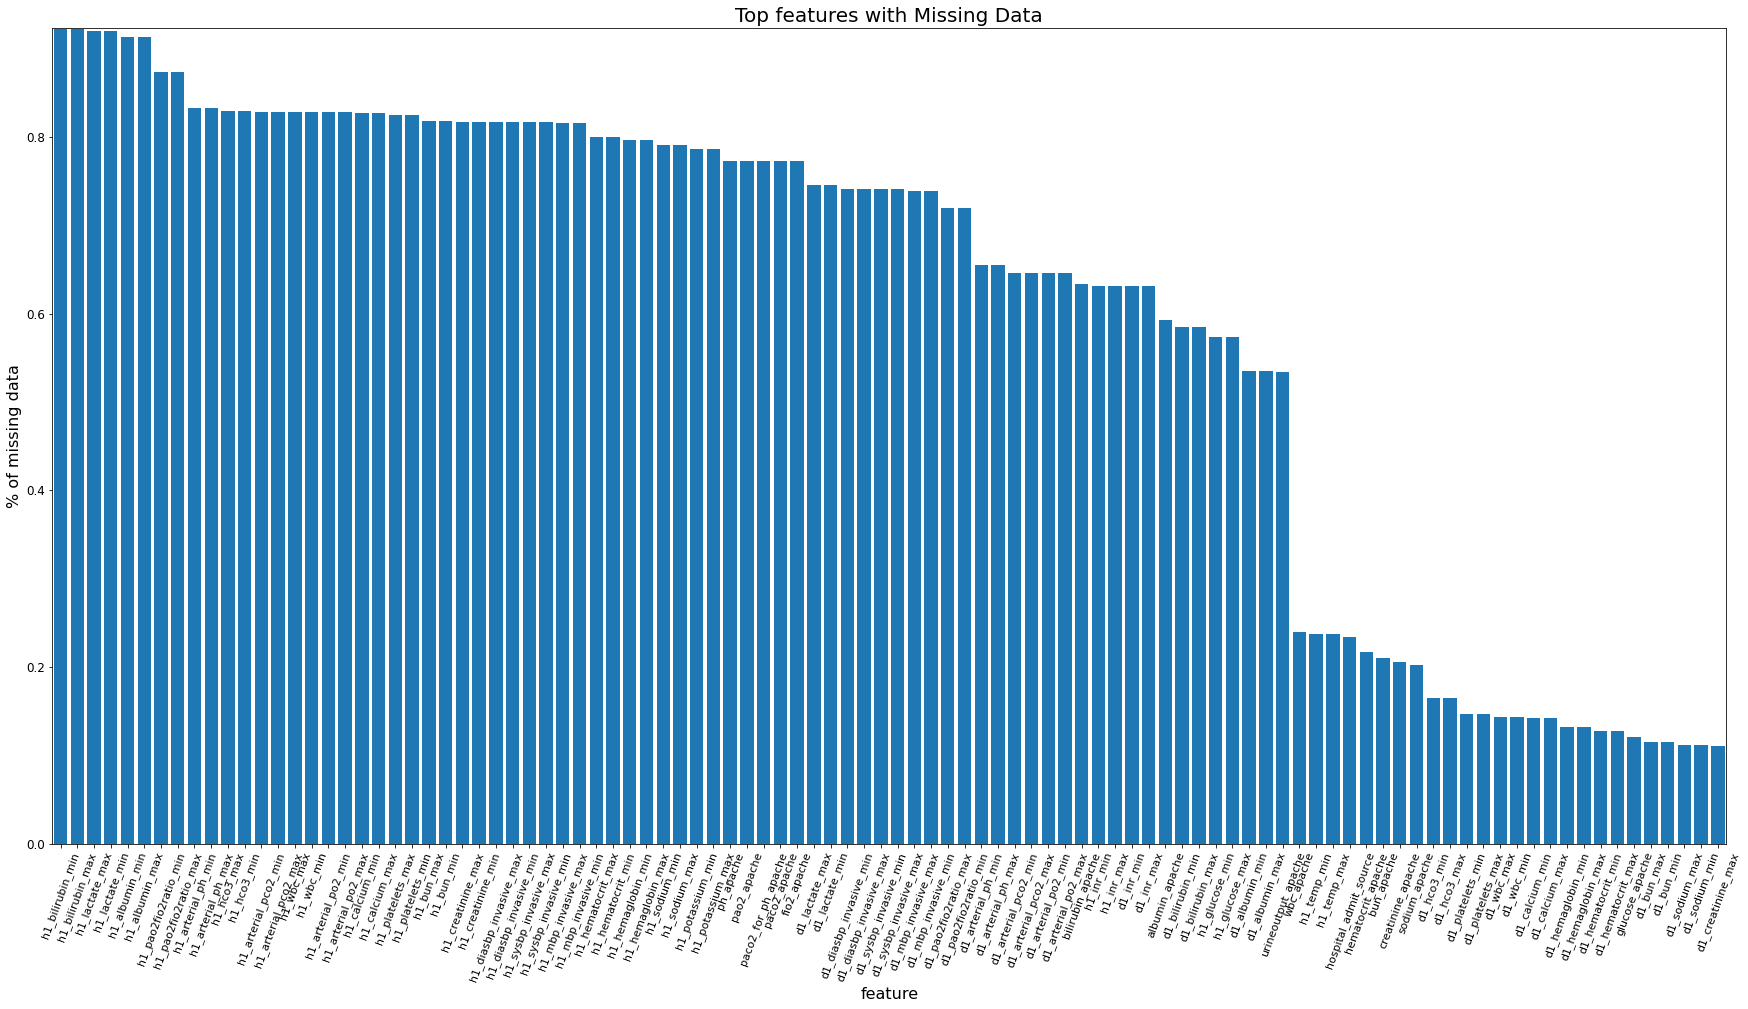

In [ ]:
plt.figure(figsize=(30,15))

plt.bar(nan_values_per_feature_pct.index[:100], nan_values_per_feature_pct[:100])
plt.xlabel('feature', fontsize=16)
plt.ylabel('% of missing data', fontsize=16)
plt.title('Top features with Missing Data', fontsize=20)
plt.xticks(fontsize=11, rotation=70)
plt.margins(0.001)

plt.savefig('Top features with Missing Data.png')

###### Missing values matrix visualization

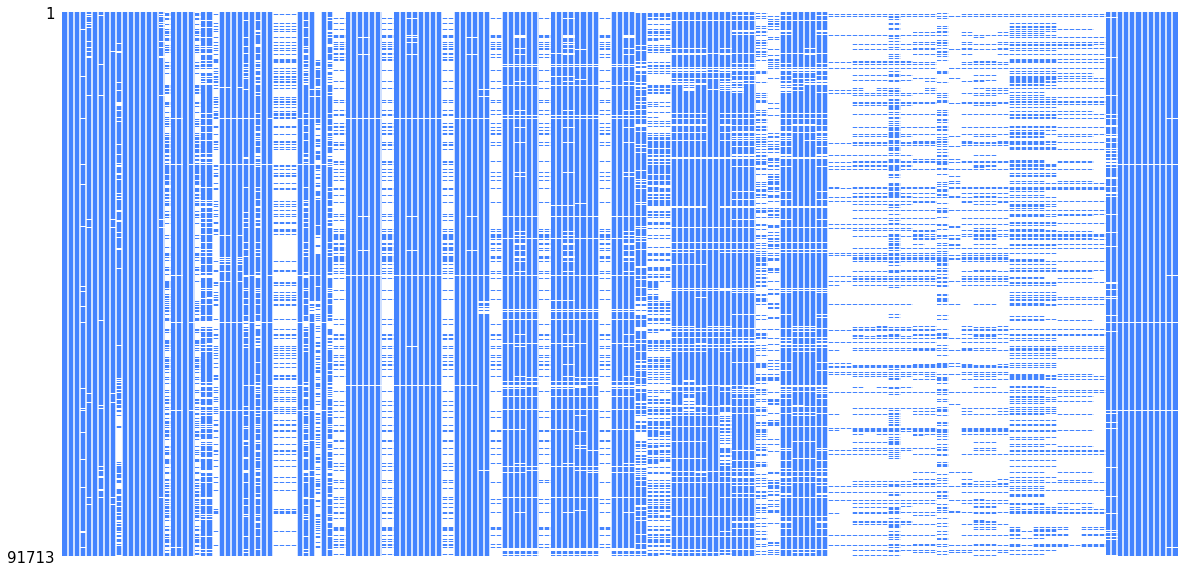

In [ ]:
missingno.matrix(train_df, sparkline=False, figsize=(20,10), fontsize=12, color=(0.27, 0.52, 1.0))
plt.show()

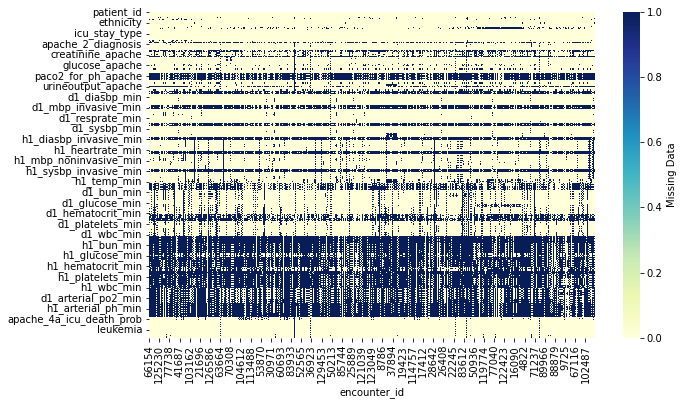

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()


### **more data visualizations**

##### Dendrogram visualization - finda groupings of features that are correlated

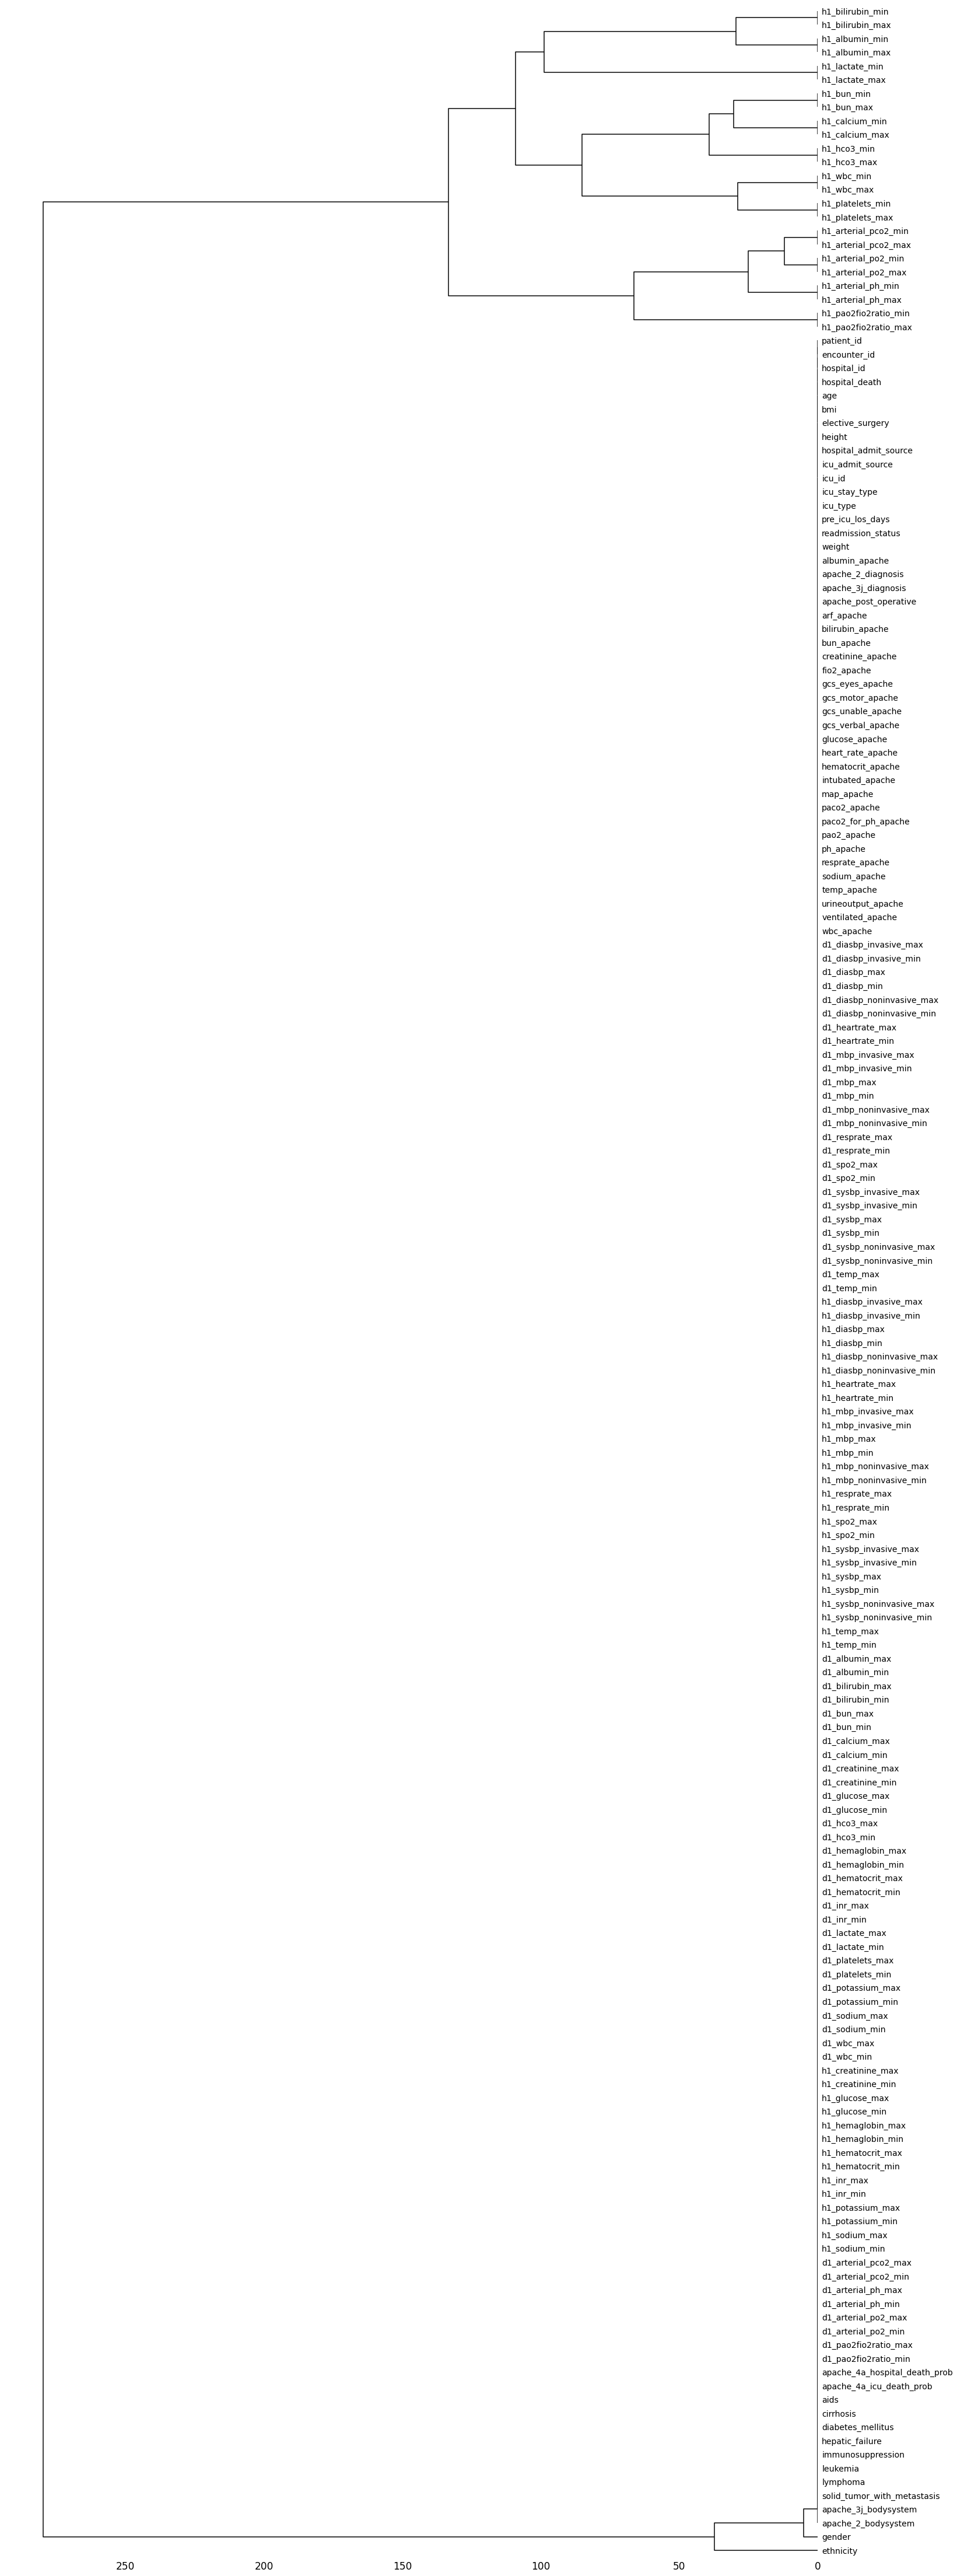

In [ ]:
# hierachical clustering
msno.dendrogram(train_df,fontsize=14)

##### visualization of the data

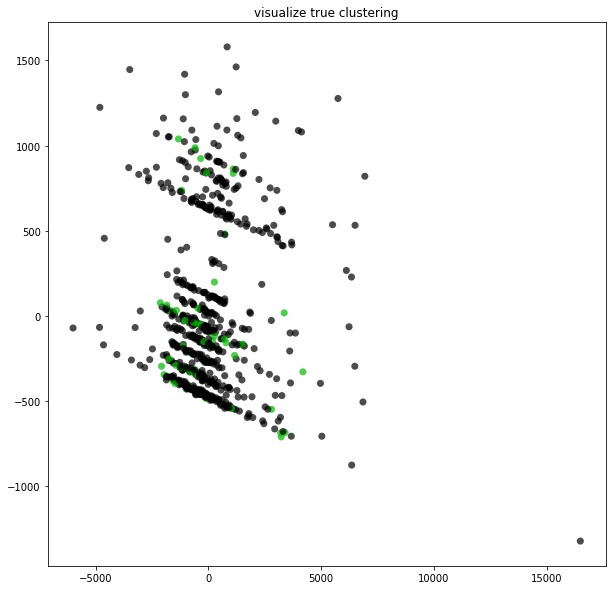

In [ ]:
reduction = PCA(n_components=3)
projected = reduction.fit_transform(x_imputed) # must be encoded first
x = projected[:,0]
y = projected[:,1]

colors = cm.nipy_spectral(train_df['hospital_death']/2)

plt.figure(figsize=(10,10))
plt.scatter(x, y, s=50, lw=0, alpha=0.7, c=colors, edgecolor="k")
plt.title('visualize true clustering')
plt.show()

# Preprocessing

###### drop features

In [ ]:
# remove unneccesary features features we do not want to bias the model towards these factors

to_drop = set(['encounter_id', 'patient_id'])# consider dropping , 'icu_id', 'hospital_id'
print("The total number of features that need to be deleted:", len(to_drop))

The total number of features that need to be deleted: 2


In [ ]:
# remove features with only one unique value 

nununique_vals = train_df.nunique()
for ind, f in enumerate(nununique_vals):
  if f == 1:
    print(f"nun-unique values of columns '{nununique_vals.index[ind]}' detected")
    to_drop.add(nununique_vals.index[ind])

print("The total number of features that need to be deleted after the features with with only 1 unique value have been added", len(to_drop))

nun-unique values of columns 'readmission_status' detected
The total number of features that need to be deleted after the features with with only 1 unique value have been added 3


In [ ]:
# remove features with more than the predefined threshold of missing values

missing_values_threshold = 0.8 #TODO lower the threshold
nan_features_to_drop = nan_values_per_feature[nan_values_per_feature_pct > missing_values_threshold].index

for f in nan_features_to_drop:
  to_drop.add(f)
print("The total number of features that need to be deleted after the features with many missing values have been added:",len(to_drop))


The total number of features that need to be deleted after the features with many missing values have been added: 37


In [ ]:
train_features =  [col for col in train_df.columns if col not in to_drop] 
print("Number of features left for model training:", len(train_features))

Number of features left for model training: 149


#### Encode categorical values

In [ ]:
def encode_categorical(data):
  return pd.get_dummies(data)

#### Handle with missing values

In [ ]:
def complete_case(data):
  return data.dropna()

def keep_the_missing(data):
  return data

def missing_category(data):
  categoricals_features =[feature for feature in data.columns if data[feature].dtype == object]
  numerical_features = list(set(data.columns) - set(categoricals_features))

  data[categoricals_features] = data[categoricals_features].apply(lambda x:x.fillna('missing'))
  # data[numerical_features] = data[numerical_features].apply(lambda x:x.fillna(-1))
  for feature in numerical_features:
    na_index = data[feature].isna().index
    data[feature+'_missing'] = np.zeros(data.shape[0])
    data.loc[na_index, feature+'_missing'] = 1
    data[feature].fillna(-1)
  return data

def simple_imputation(data):
  dummies = pd.get_dummies(data)
  imp = SimpleImputer(strategy='median')
  return pd.DataFrame(imp.fit_transform(dummies), columns = dummies.columns)

def multi_imputation(data):
  dummies = pd.get_dummies(data)
  imp = IterativeImputer(max_iter=5, random_state=11)
  return pd.DataFrame(imp.fit_transform(dummies), columns = dummies.columns)

def handle_missing(data, method):
  copy = data.copy()
  missing_method = missing_dict.get(method)
  return missing_method(copy)


missing_dict = {'complete_case': complete_case, 'keep_the_missing': keep_the_missing,
                'missing_category': missing_category, 'simple_imputation':simple_imputation, 
                'multi_imputation':multi_imputation}

In [ ]:
# experiments on missing
results = {}
for method in missing_dict.keys():
  print(method)
  data_not_missing = handle_missing(train_df[train_features], method)
  print(data_not_missing.shape)
  if method == 'simple_imputation' or method == 'multi_imputation':
    X = data_not_missing.drop('hospital_death', axis=1)
  else:
    X = encode_categorical(data_not_missing.drop('hospital_death', axis=1))
  y = data_not_missing['hospital_death']
  # xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=SEED)
  xgbr_model = XGBClassifier(random_state=SEED, verbosity=0,objective='binary:logistic', missing=np.nan)
  scores = cross_val_model(xgbr_model, X,y)
  print(scores.mean(), scores.std())
  
  results[method] = (scores.mean(), scores.std())

results

complete_case
(142, 149)
0.7709090909090909 0.04228524608568437
keep_the_missing
(91713, 149)


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


0.8956716018079935 0.0036483342353805194
missing_category


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(91713, 290)


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


0.895526862129546 0.003209460915901462
simple_imputation
(91713, 201)
0.8938917439708713 0.003786320870108263
multi_imputation


[IterativeImputer] Early stopping criterion not reached.


(91713, 201)
0.92805152659241 0.0018127351185382224


{'complete_case': (0.7709090909090909, 0.04228524608568437),
 'keep_the_missing': (0.8956716018079935, 0.0036483342353805194),
 'missing_category': (0.895526862129546, 0.003209460915901462),
 'multi_imputation': (0.92805152659241, 0.0018127351185382224),
 'simple_imputation': (0.8938917439708713, 0.003786320870108263)}

compare imputed values to the original values

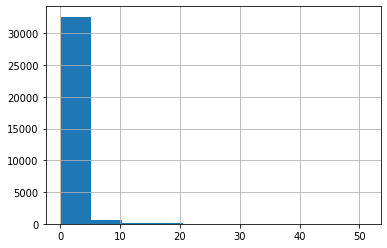

In [ ]:
train_df["bilirubin_apache"].dropna().hist()

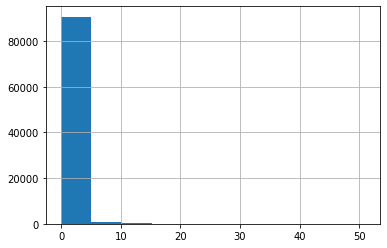

In [ ]:
X["bilirubin_apache"].hist()

# Modeling alternatives

In [ ]:
X = handle_missing(train_df[train_features], 'simple_imputation').drop('hospital_death', axis=1)
y = train_df['hospital_death']

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
def cross_val_model(model, xtrain, ytrain):
  # cross validation 
  metrics = {"auc":"roc_auc","acc":"balanced_accuracy", "precision":"average_precision", "recall":"recall"}
  kfold = StratifiedKFold(n_splits=5, shuffle=True)
  kf_cv_scores = cross_val_score(model, xtrain, ytrain, cv=kfold ,scoring="roc_auc", n_jobs=-1)
  return kf_cv_scores

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test,y_pred, normalize="true")
  ConfusionMatrixDisplay(confusion_matrix = cm).plot()

def plot_roc_curve(y_test, y_pred, model_name):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.roc_auc_score(y_test, y_pred)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc="best")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(model_name + " - ROC curve")
    plt.show()
    plt.close()

def plot_cutoffs(yprob, ytest):
  thresh = np.arange(0,1.1,0.1) 
  sens = []
  pcts = []
  for t in thresh:
    y_pred = [1 if y > t else 0 for y in yprob]
    cm1 = confusion_matrix(ytest,y_pred)
    sensitivity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sens.append(sensitivity)
    pct_pos = y_pred.count(1)/len(y_pred)
    pcts.append(pct_pos)
  plt.plot(pcts[::-1], sens, label="cuttofs view")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.legend(loc="best")
  plt.ylabel('Sensitivity')
  plt.xlabel('Percentage positive')
  plt.title("Sensitivity as a function of percent positives")
  plt.show()
  plt.close()

def plot_precision_recall_curve(yhat, ytest, lr_probs):
  lr_precision, lr_recall, _ = precision_recall_curve(ytest, lr_probs)
  lr_f1, lr_auc = f1_score(ytest, yhat), auc(lr_recall, lr_precision)

  # summarize scores
  # print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
  no_skill = len(ytest[ytest==1]) / len(ytest)
  # plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  plt.plot(lr_recall, lr_precision, label='area = %0.2f' % lr_auc )
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title("Precision-Recall Curve")
  plt.legend()
  plt.show()
  plt.close()


In [ ]:
def evaluate(model, ytrue, xtest):
  y_pred = model.predict(xtest)
  yprob = model.predict_proba(xtest)
  yprob = yprob[:,1]

  plot_roc_curve(ytrue, yprob,"")
  plot_cutoffs(yprob, ytrue)
  plot_precision_recall_curve(y_pred, ytrue, yprob)
  plot_confusion_matrix(ytrue.astype(float),y_pred.astype(float))

###### XGBoost

In [ ]:
def fit_eval_xbg_model(xtrain, ytrain,xtest, ytest, weights=False):
  # class weights
  positive = list(y).count(1)
  negative = len(y) - positive
  weight = negative/positive

  # train model
  if weights:
    xgbr_model = XGBClassifier(random_state=SEED, verbosity=0,objective='binary:logistic', weights=[weight])
  else:
    xgbr_model = XGBClassifier(random_state=SEED, verbosity=0,objective='binary:logistic')

  cross_val_scores = cross_val_model(xgbr_model, xtrain, ytrain)
  print("mean and std of cross validation score: ", cross_val_scores.mean(), cross_val_scores.std())

  xgbr_model.fit(xtrain, ytrain)
  evaluate(xgbr_model, ytest, xtest)
  plot_calibration_curve(xgbr_model, "xgbr_model",xtest, ytest)
  compute_feature_importance_with_SHAP(xgbr_model, xtest)


  xgb_params = {"random_state":SEED, "verbosity":0,"objective":'binary:logistic', "weights":[weight]}
  bootstrap_CI(XGBClassifier,xgb_params, xtrain, ytrain)

  return xgbr_model


def fit_eval_lr_model(xtrain, ytrain, weights=False):

  x_scaled = StandardScaler().fit_transform(xtrain)
  if weights:
    positive = list(y).count(1)
    negative = len(y) - positive
    weight_1 = negative/positive
    weight_0 = positive/negative
    logistic_model = LogisticRegression(max_iter=100000, class_weight={0:weight_0, 1:weight_1})
  else:
    logistic_model = LogisticRegression(max_iter=100000)
  logistic_model.fit(xtrain, ytrain)

  # train model
  kf_cv_scores = cross_val_model(logistic_model, x_scaled, ytrain)
  print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
  evaluate(logistic_model, ytest, xtest)

  plot_calibration_curve(logistic_model, "logistic_model",xtest, ytest)
  # Feature importance computed with SHAP values
  compute_feature_importance_with_SHAP(logistic_model, xtest)

  bootstrap_CI(LogisticRegression,{'max_iter':100000}, xtrain, ytrain)

  return logistic_model



mean and std of cross validation score:  0.9275152094524939 0.0016541369930567922


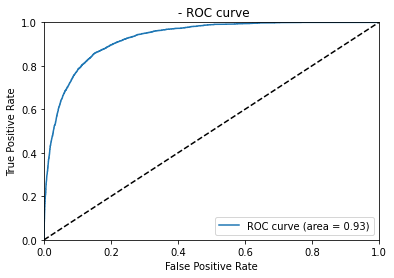

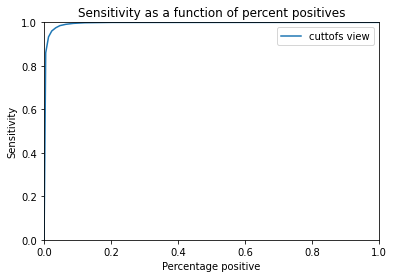

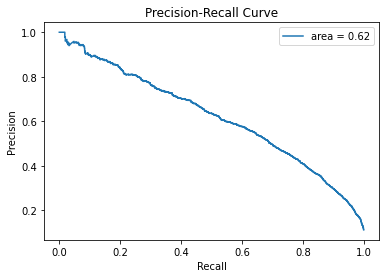

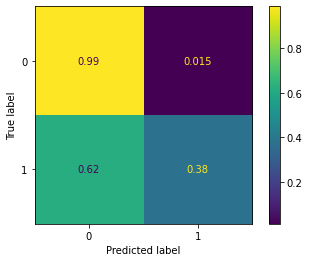

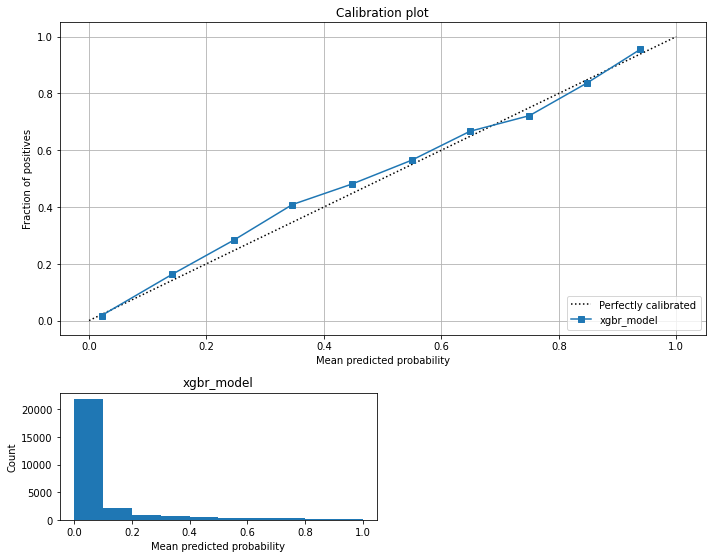

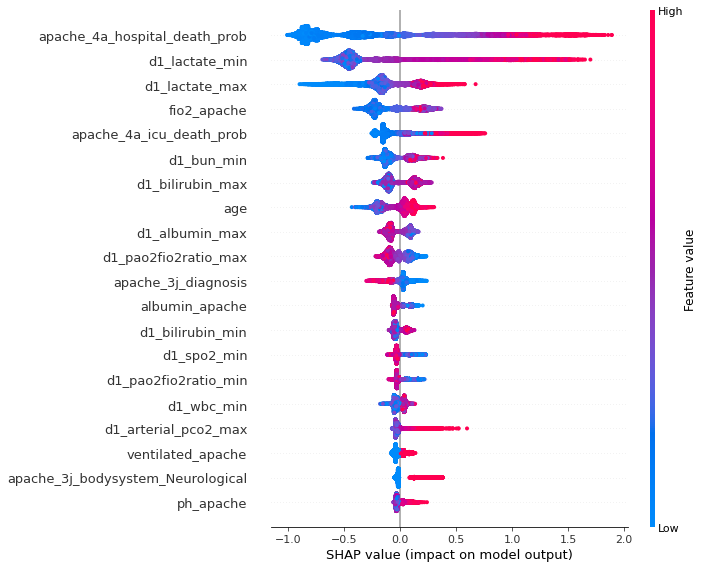

In [ ]:
xgbr_model = fit_eval_xbg_model(xtrain, ytrain, xtest, ytest)

###### CatBoost

In [ ]:
from catboost import CatBoostClassifier

def fit_eval_cb_model(xtrain, ytrain, weights=False):

  if weights:
    positive = list(y).count(1)
    negative = len(y) - positive
    weight_1 = negative/positive
    weight_0 = positive/negative
    CatBoost_model = CatBoostClassifier(iterations=100, verbose=0, class_weights={0:weight_0, 1:weight_1})
    params = {"iterations":100, "verbose":0, "class_weights":{0:weight_0, 1:weight_1}}
  else:
    CatBoost_model = CatBoostClassifier(iterations=100, verbose=0)
    params = {"iterations":100, "verbose":0}


  CatBoost_model.fit(xtrain, ytrain)
  kf_cv_scores = cross_val_model(CatBoost_model, xtrain, ytrain)
  print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
  evaluate(CatBoost_model, ytest, xtest)

  plot_calibration_curve(CatBoost_model, "CatBoost_model",xtest, ytest)
  # Feature importance computed with SHAP values
  compute_feature_importance_with_SHAP(CatBoost_model, xtest)

  bootstrap_CI(CatBoostClassifier,params, xtrain, ytrain)

  return CatBoost_model

K-fold CV average score:  0.9297052216241344 0.003955091378122361


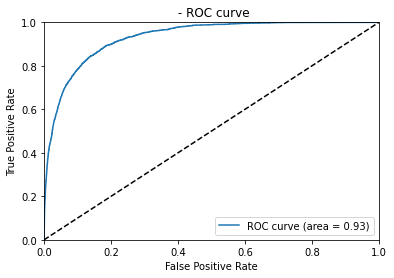

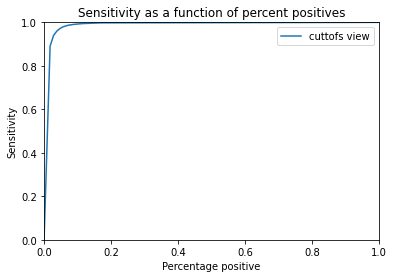

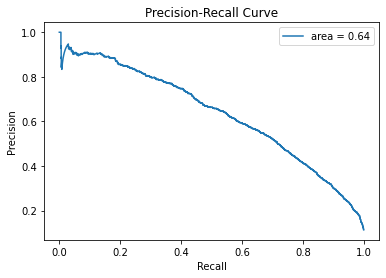

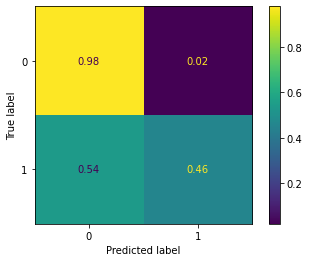

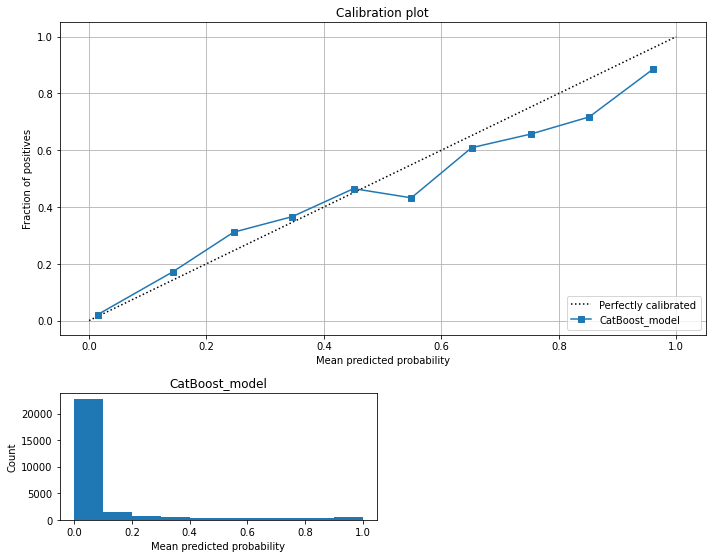

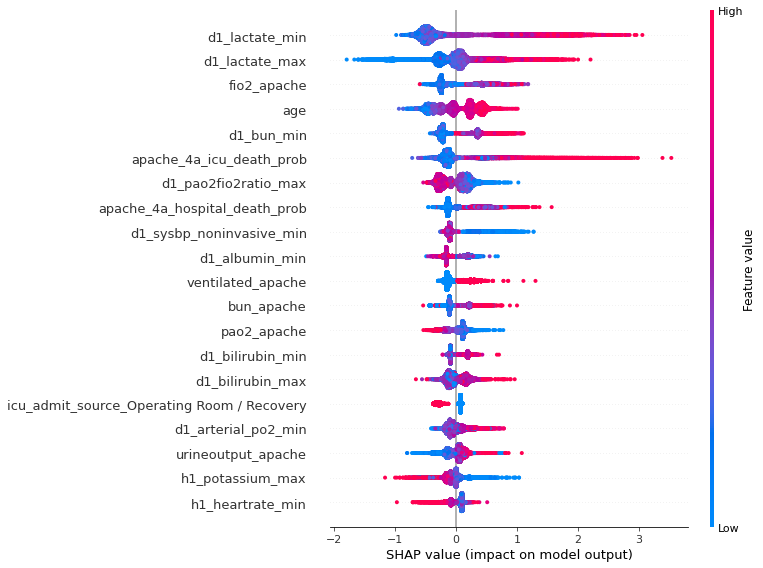

In [ ]:
catb_model = fit_eval_cb_model(xtrain, ytrain, xtest, ytest)

# Calibration

In [ ]:
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

def plot_calibration_curve(model, model_name,X_test, y_test):
  fig = plt.figure(figsize=(10, 10))
  gs = GridSpec(4, 2)
  colors = plt.cm.get_cmap("Dark2")
  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  display = CalibrationDisplay.from_estimator(
    model,
    X_test,
    y_test,
    n_bins=10,
    name=model_name,
    ax=ax_calibration_curve,
  )
  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plot")

  # Add histogram
  grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
  row, col = grid_positions[0]
  ax = fig.add_subplot(gs[row, col])
  ax.hist(
      display.y_prob,
      range=(0, 1),
      bins=10,
      label=model_name,
  )
  ax.set(title=model_name, xlabel="Mean predicted probability", ylabel="Count")
  plt.tight_layout()
  plt.show()

def calibrate_clf(model, model_name, X_train, y_train,X_test, y_test):
  plot_calibration_curve(model, model_name,X_test, y_test)
  calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
  calibrated.fit(X_train, y_train)
  plot_calibration_curve(calibrated, model_name,X_test, y_test)

  return calibrated

# Expalinability

#### Global

In [ ]:
# compute feature importance with SHAP values
def compute_feature_importance_with_SHAP(model,x_test):
  try:
    explainer = shap.TreeExplainer(model)
  except:
    explainer = shap.LinearExplainer(model,shap.maskers.Independent(x_test, max_samples=100))
  shap_values = explainer.shap_values(xtest)
  shap.summary_plot(shap_values, xtest)


In [ ]:
# Feature importance computed with feature_importances_ attribute given as 'importance' input

def plot_feature_importance(importance,feature_names,model_type):  
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(feature_names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  fi_df = fi_df[:40]
  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

#### Local

In [ ]:
sample_id = 103
shap.initjs()
explainer = shap.TreeExplainer(xgbr_model)
shap_values = explainer.shap_values(xtest)
pd.set_option("max_columns", 185)
print((xtest.iloc[sample_id,:][["age", "gender_M","gender_F", "bmi", "apache_2_diagnosis", "apache_3j_diagnosis", "ethnicity_African American", "ethnicity_Asian", "ethnicity_Caucasian", "ethnicity_Hispanic", "ethnicity_Native American", "ethnicity_Other/Unknown"]]))
print("hospital_death:", ytest.iloc[sample_id])
shap.force_plot(explainer.expected_value, shap_values[sample_id,:], xtest.iloc[sample_id,:])

age                            77.000000
gender_M                        0.000000
gender_F                        1.000000
bmi                            38.177014
apache_2_diagnosis            109.000000
apache_3j_diagnosis           108.010000
ethnicity_African American      0.000000
ethnicity_Asian                 0.000000
ethnicity_Caucasian             1.000000
ethnicity_Hispanic              0.000000
ethnicity_Native American       0.000000
ethnicity_Other/Unknown         0.000000
Name: 103, dtype: float64
hospital_death: 1


In [ ]:
sample_id = 100
shap.initjs()
explainer = shap.TreeExplainer(xgbr_model)
shap_values = explainer.shap_values(xtest)
pd.set_option("max_columns", 185)
print((xtest.iloc[sample_id,:][["age", "gender_M","gender_F", "bmi", "apache_2_diagnosis", "apache_3j_diagnosis", "ethnicity_African American", "ethnicity_Asian", "ethnicity_Caucasian", "ethnicity_Hispanic", "ethnicity_Native American", "ethnicity_Other/Unknown"]]))
print("hospital_death:", ytest.iloc[sample_id])
print(xgbr_model.predict(xtest)[sample_id])
shap.force_plot(explainer.expected_value, shap_values[sample_id,:], xtest.iloc[sample_id,:])

age                            86.000000
gender_M                        1.000000
gender_F                        0.000000
bmi                            30.863777
apache_2_diagnosis            113.000000
apache_3j_diagnosis           501.050000
ethnicity_African American      0.000000
ethnicity_Asian                 0.000000
ethnicity_Caucasian             1.000000
ethnicity_Hispanic              0.000000
ethnicity_Native American       0.000000
ethnicity_Other/Unknown         0.000000
Name: 86070, dtype: float64
hospital_death: 1
1


# Uncertainty analasis

In [ ]:
def bootstrap_CI(model_class,model_params, xdata, ydata):
  def plot_bootsrap_distribution(stats):
      # plot scores
      plt.hist(stats)
      plt.title("Distribution of Classification AUC Using the Bootstrap")
      plt.show()

  def calc_CI(stats):
      # confidence intervals
      alpha = 0.95
      p = ((1.0-alpha)/2.0) * 100
      lower = max(0.0, np.percentile(stats, p))
      p = (alpha+((1.0-alpha)/2.0)) * 100
      upper = min(1.0, np.percentile(stats, p))
      print('showing that there is a %.1f likelihood that the confidence interval %.1f%% and %.1f%% covers the true skill of the model' % (alpha*100, lower*100, upper*100))

  # configure bootstrap
  n_iterations = 1000
  n_size = int(len(xdata) * 0.50)

  # run bootstrap
  stats = list()
  for i in range(n_iterations):
    # prepare train and test sets
    x, y = resample(xdata, ydata, n_samples=n_size)
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=SEED)
    model = model_class()
    model.set_params(**model_params)
    model.fit(xtrain, ytrain)
    predictions = model.predict(xtest)
    predictions_p = model.predict_proba(xtest)[:,1]
    try:
      auc_score = metrics.roc_auc_score(ytest.values, predictions_p)
      stats.append(auc_score)
    except ValueError:
      pass

  plot_bootsrap_distribution(stats)
  calc_CI(stats)



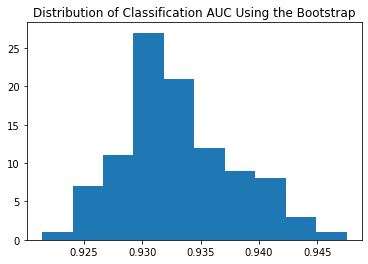

showing that there is a 95.0 likelihood that the confidence interval 92.5% and 94.4% covers the true skill of the model


In [ ]:
xgb_params = {"random_state":SEED, "verbosity":0,"objective":'binary:logistic'}
bootstrap_CI(XGBClassifier,xgb_params, xtrain, ytrain)

# Unfairness analasis

In [ ]:
def plot_death_distribution_by_subgroups(df, subgroup_name):
    df[subgroup_name].hist()
    plt.show()

    g = sns.catplot(
        data=df, kind="count",
        x=subgroup_name, hue="hospital_death",
        ci="sd", palette="dark", alpha=.6, height=6,
    )
    plt.show()

def plot_subgroup_roc_calibration(subgroups, xtrain, xtest, ytest, model, columns=xtrain.columns,  group_name=None):

  for subgroup in subgroups:
    print(subgroup)
    if type(subgroup) is tuple:
      lower_val, upper_val = subgroup
      subgroup_x = xtest[(xtest[group_name]>=lower_val) & (xtest[group_name]< upper_val)][columns]
    else:
      subgroup_x = xtest[xtest[subgroup]==1][columns]
    subgroup_y = ytest.iloc[subgroup_x.index]#["hospital_death"]
    plot_calibration_curve(model, "model", subgroup_x, subgroup_y)
    ypred = model.predict_proba(subgroup_x)[:,1]
    try:
      plot_roc_curve(subgroup_y, ypred, "xgbr")
    except:
      print("only one class is present for this ethnicity: ", subgroup_y.mean())

In [ ]:
xtest = xtest.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

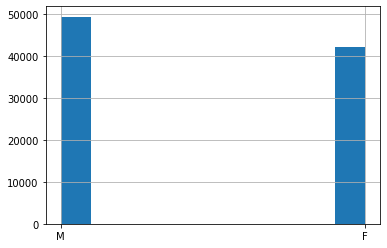

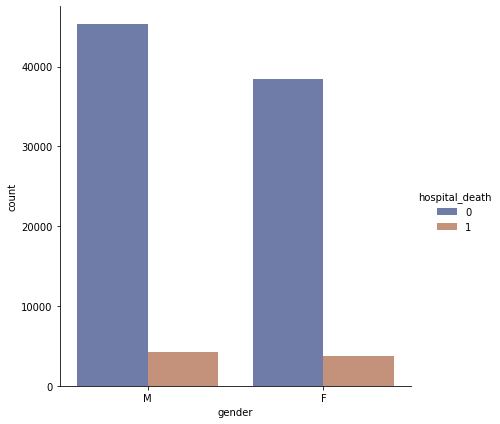

gender_F


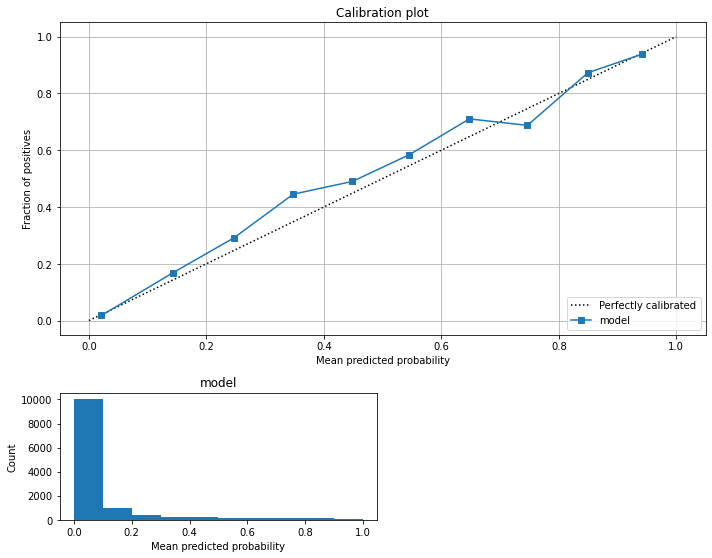

auc :  0.9302220766772656


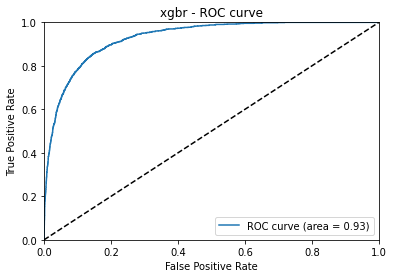

gender_M


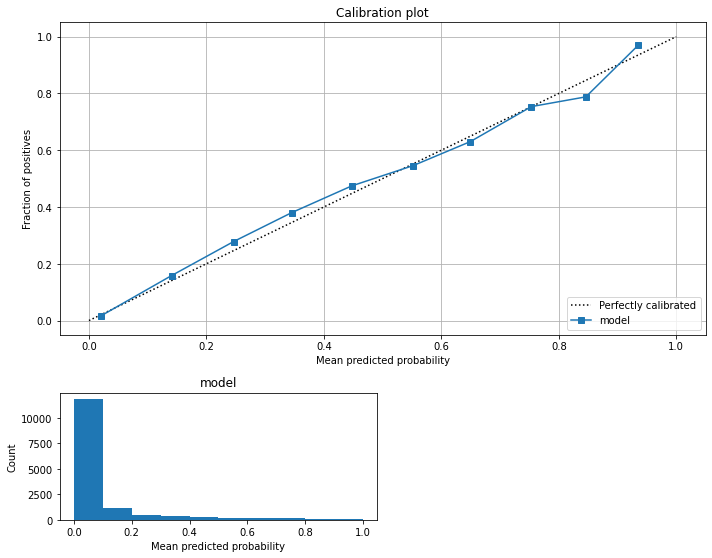

auc :  0.9273915092976497


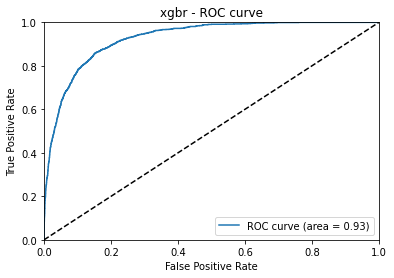

In [ ]:
# plot fairness of gender protected variable
gender_list = ["gender_F", "gender_M"]
plot_death_distribution_by_subgroups(train_df, "gender")
plot_subgroup_roc_calibration(gender_list, xtrain, xtest, ytest, xgbr_model)

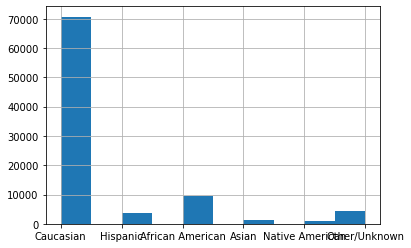

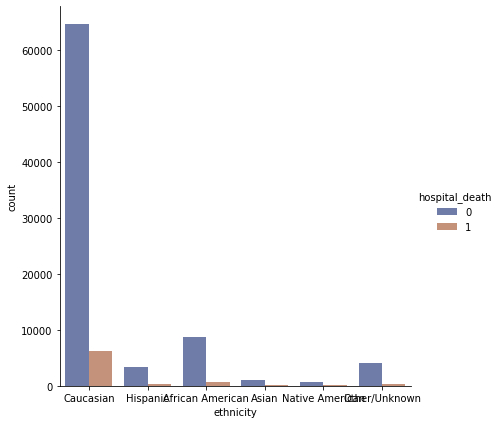

ethnicity_African American


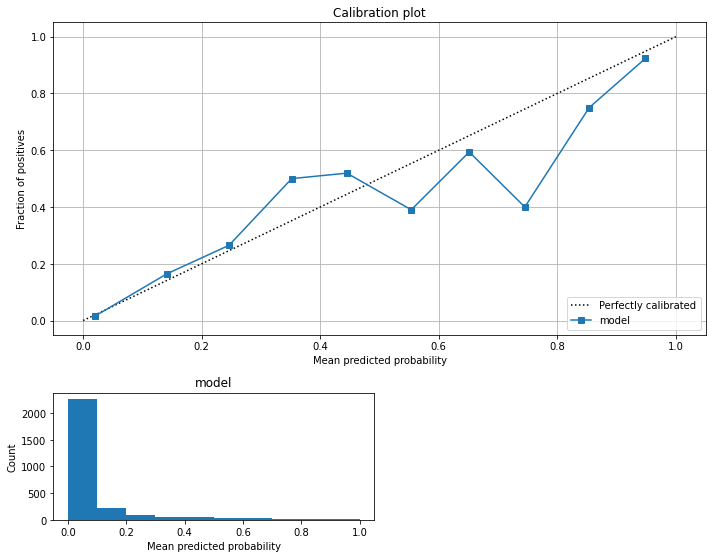

auc :  0.9197292444194071


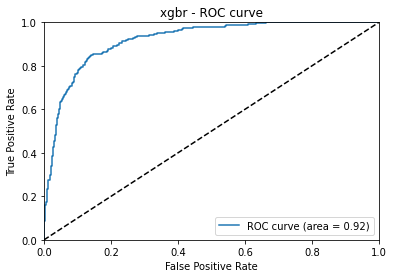

ethnicity_Asian


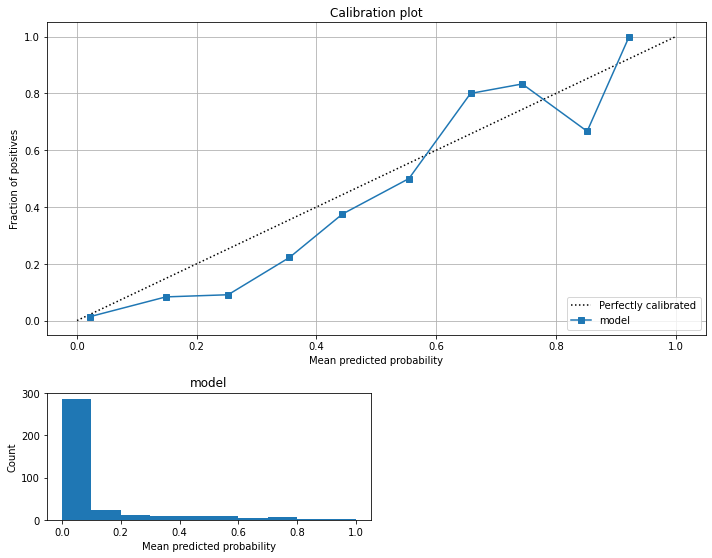

auc :  0.9265054040144107


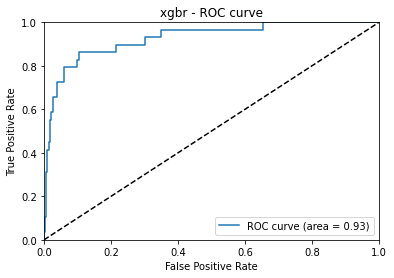

ethnicity_Caucasian


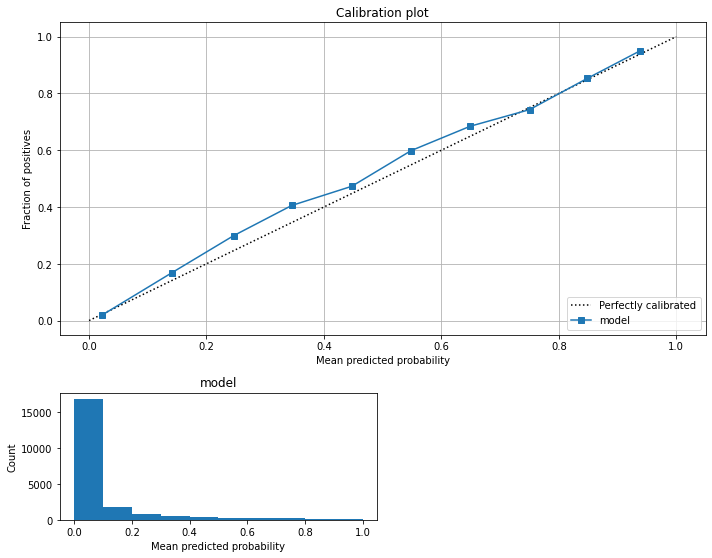

auc :  0.9276996958324553


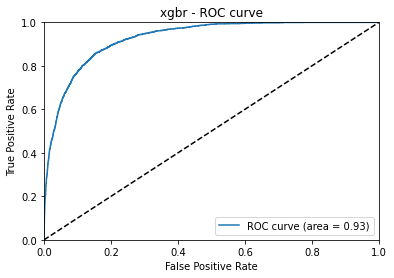

ethnicity_Hispanic


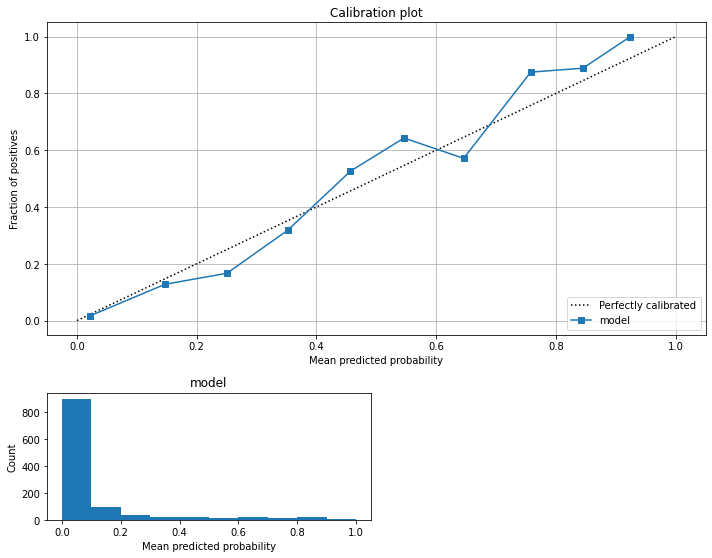

auc :  0.9349023265825964


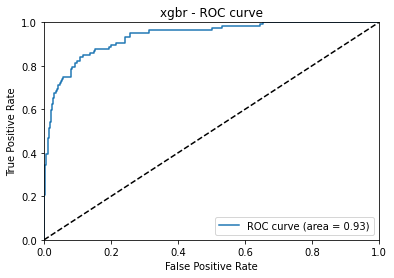

ethnicity_Native American


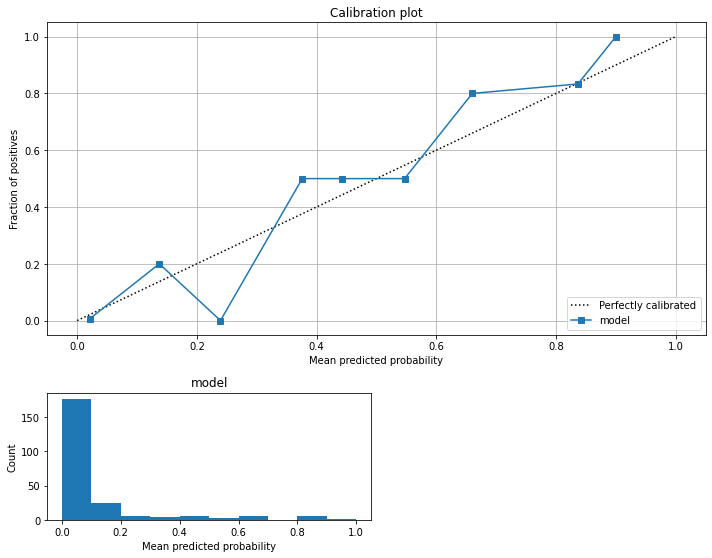

auc :  0.9536796536796537


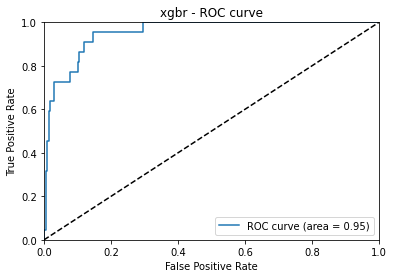

ethnicity_Other/Unknown


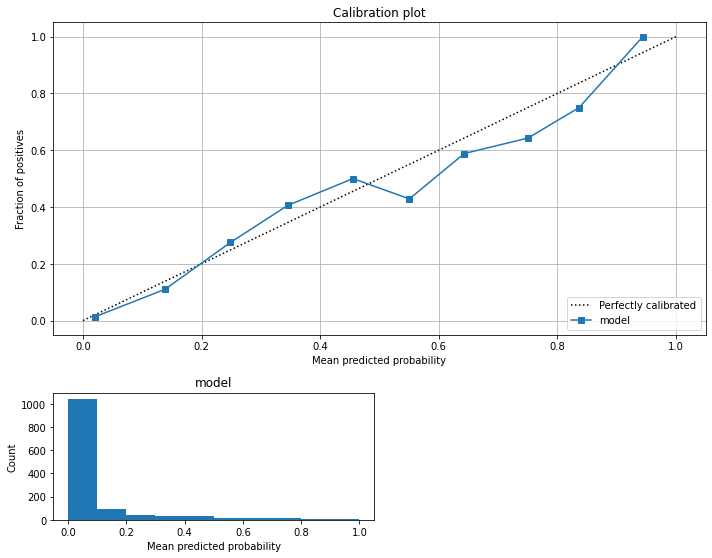

auc :  0.944834932433483


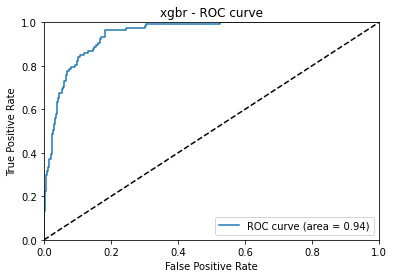

mean and std of cross validation score:  0.9269082387805273 0.003227606765514237


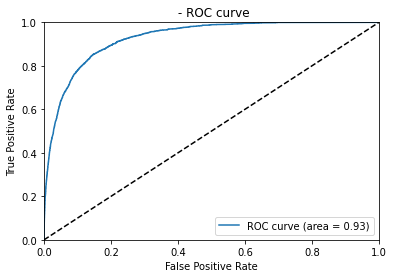

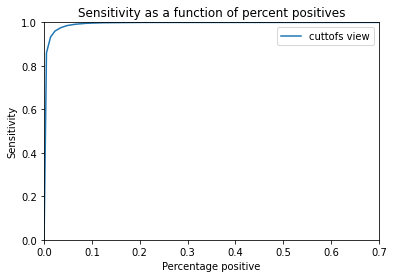

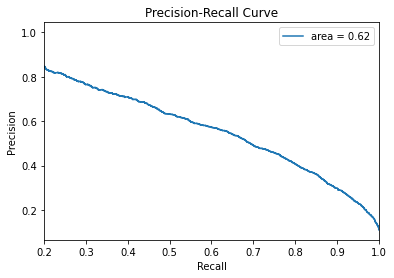

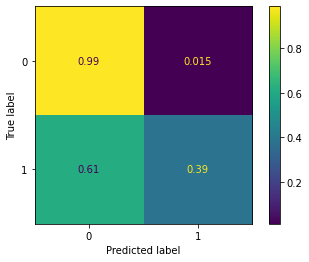

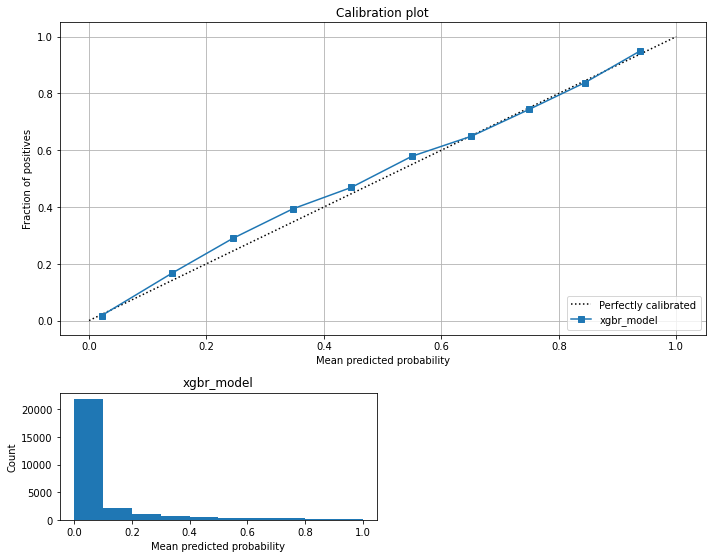

ethnicity_African American


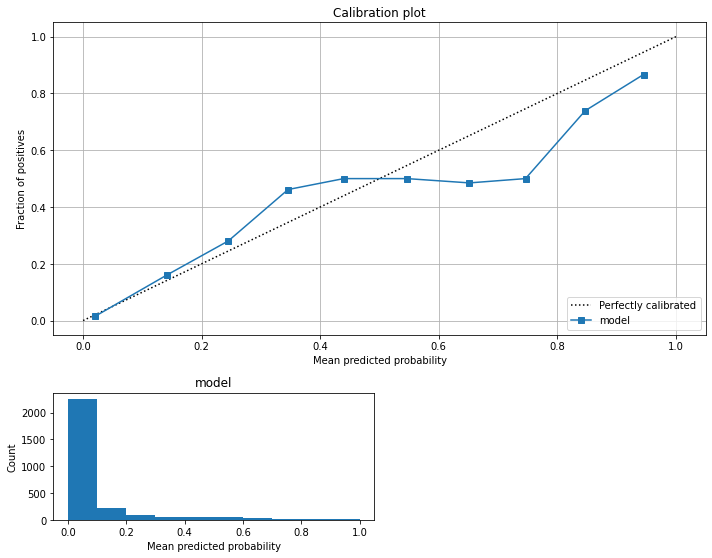

auc :  0.9194070840081685


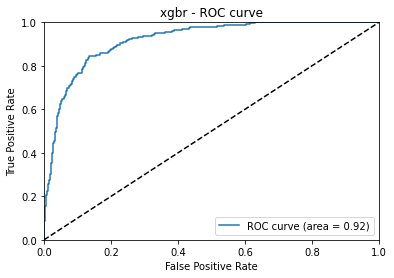

ethnicity_Asian


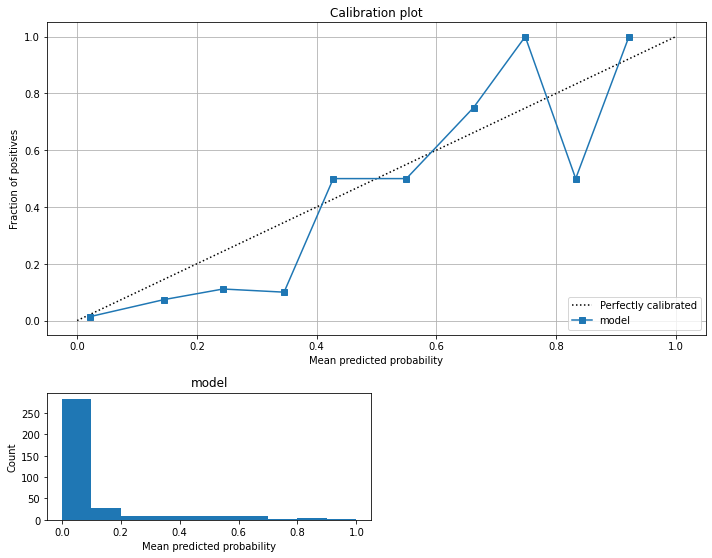

auc :  0.9266083376222337


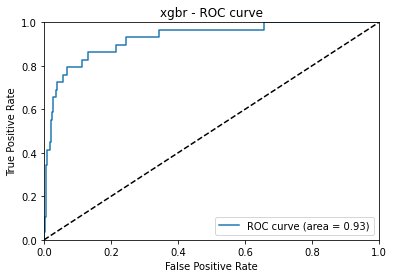

ethnicity_Caucasian


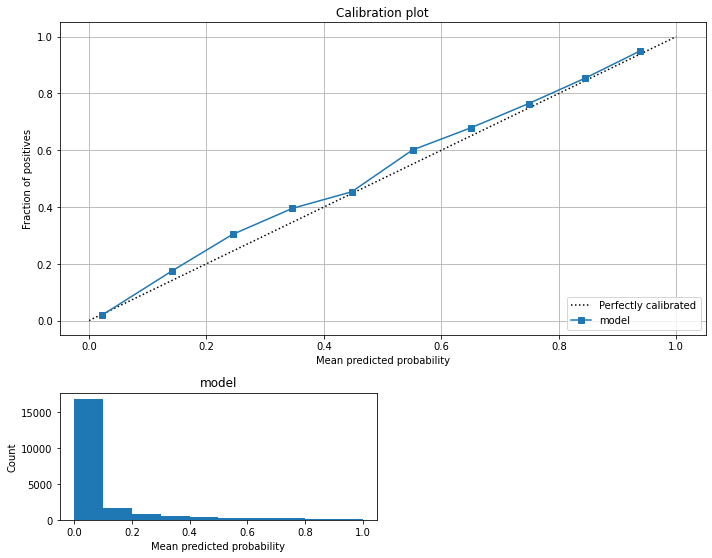

auc :  0.9275593251630384


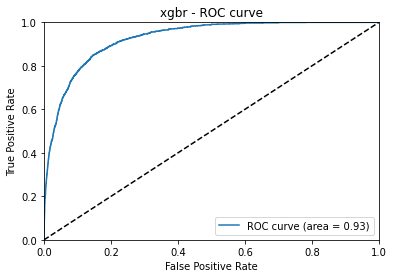

ethnicity_Hispanic


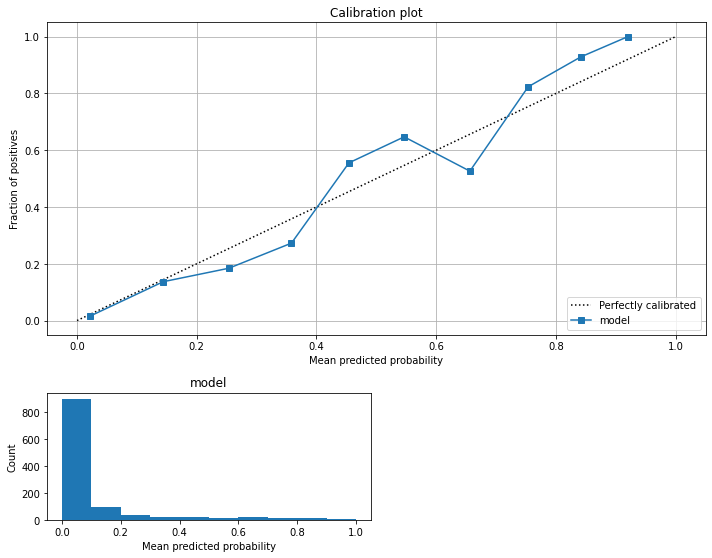

auc :  0.9347857283800025


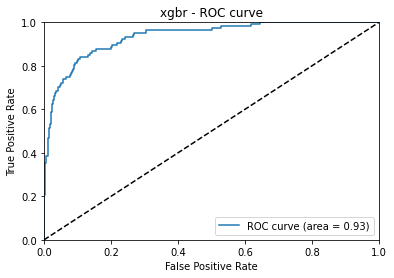

ethnicity_Native American


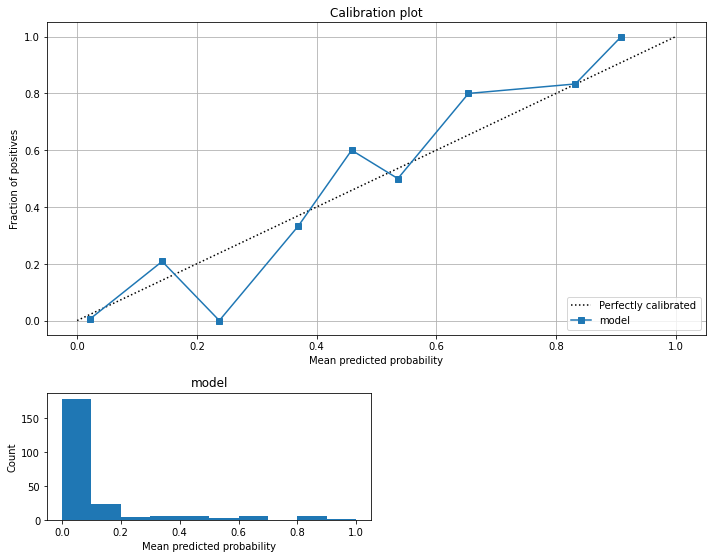

auc :  0.9532467532467532


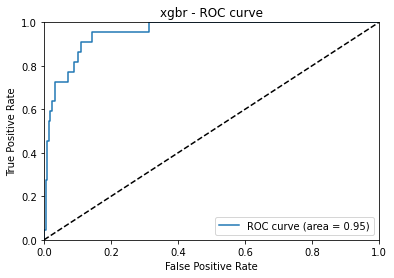

ethnicity_Other/Unknown


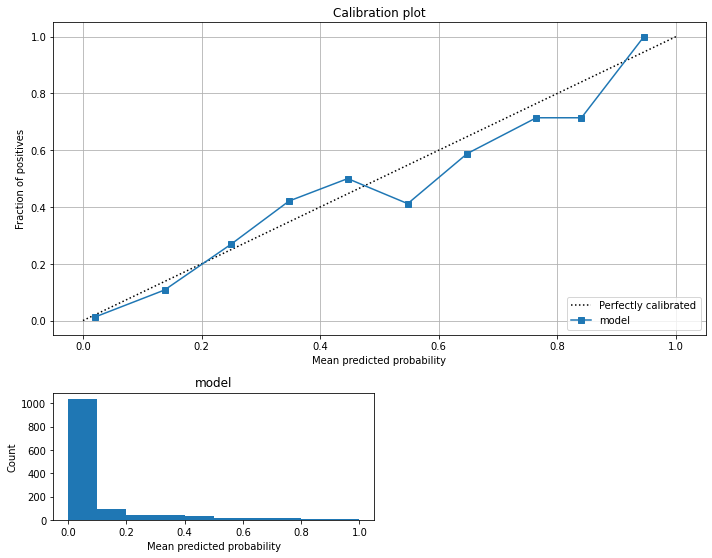

auc :  0.944764955603589


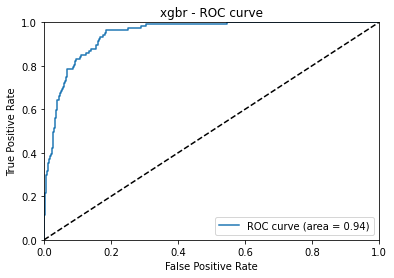

In [ ]:
# plot fairness of ethnicity protected variable
ethnicity_list = ["ethnicity_African American", "ethnicity_Asian", "ethnicity_Caucasian", "ethnicity_Hispanic", "ethnicity_Native American", "ethnicity_Other/Unknown"]
plot_death_distribution_by_subgroups(train_df, "ethnicity")
plot_subgroup_roc_calibration(ethnicity_list, xtrain, xtest, ytest, xgbr_model)

# train xbg model withput the ethnicity data
no_ethnicity_list = xtrain[xtrain.columns.difference(ethnicity_list)]
no_ethnicity_model = fit_eval_xbg_model(no_ethnicity_list, ytrain,xtest[no_ethnicity_list.columns], ytest, weights=True)
# plot again subethnicities ROC and calibration
plot_subgroup_roc_calibration(ethnicity_list, xtrain, xtest, ytest, no_ethnicity_model, columns=no_ethnicity_list.columns)

0.1    37.0
0.2    49.0
0.3    55.0
0.4    60.0
0.5    65.0
0.6    69.0
0.7    73.0
0.8    78.0
0.9    83.0
Name: age, dtype: float64


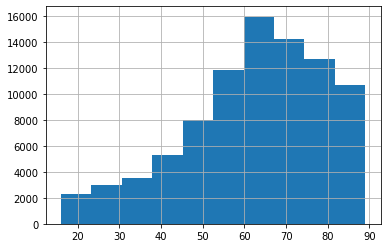

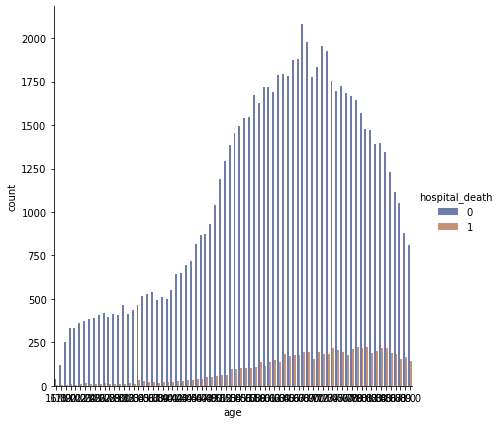

(0, 38)


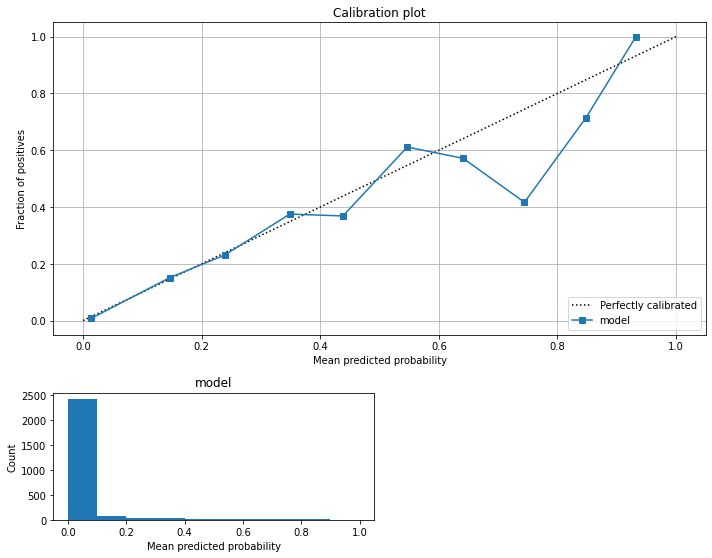

auc :  0.9468594584638055


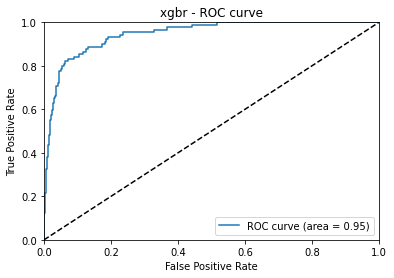

(38, 50)


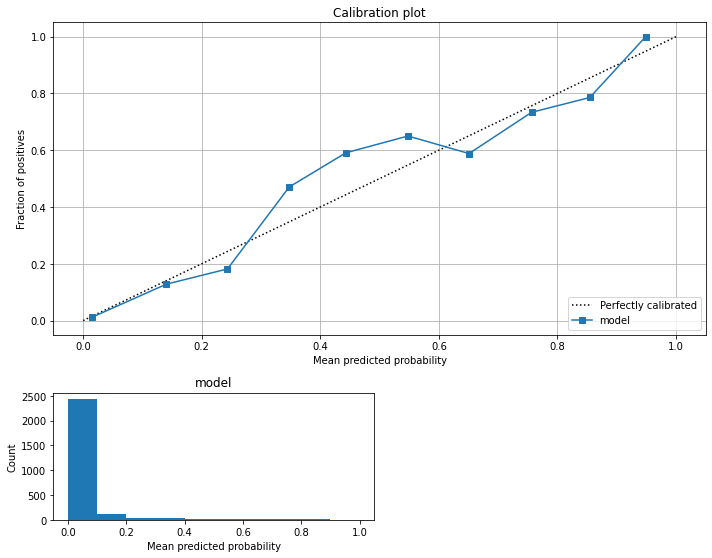

auc :  0.9452164200614912


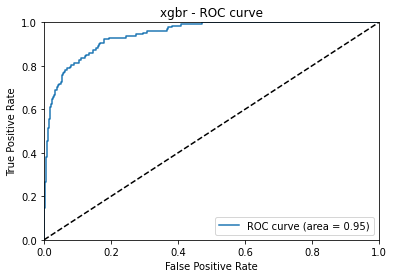

(50, 61)


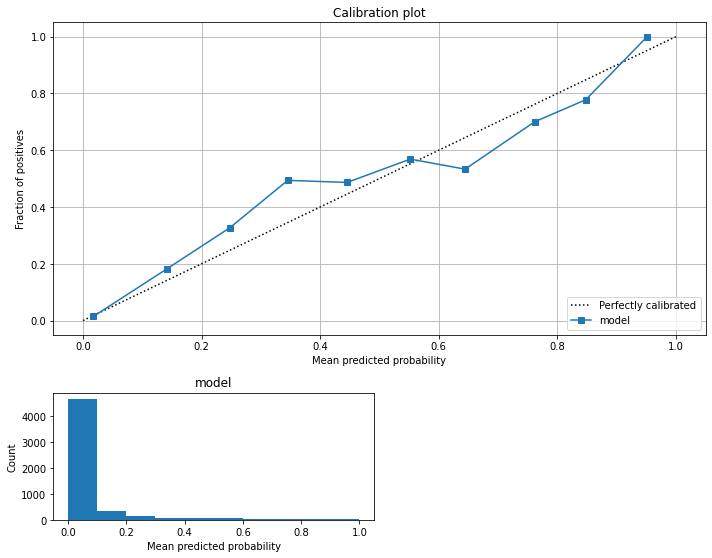

auc :  0.9405422534454793


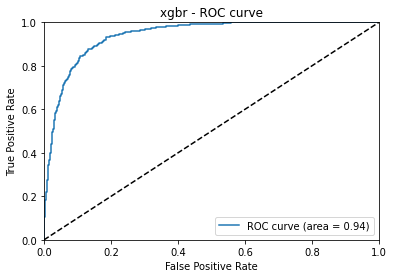

(61, 63)


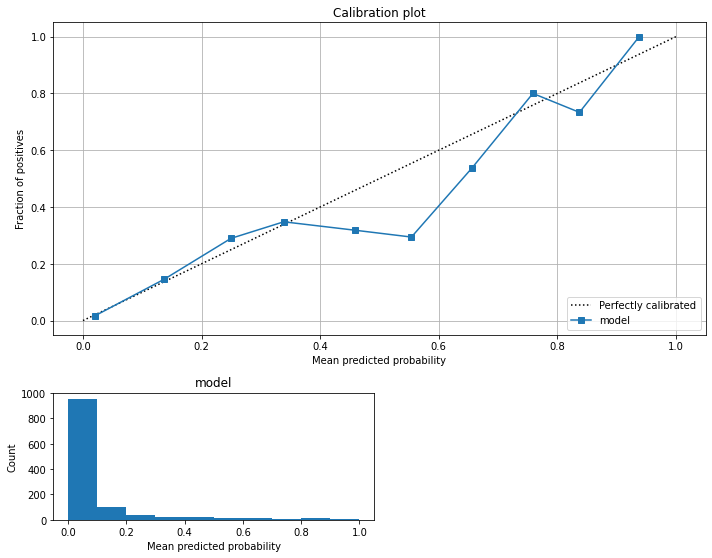

auc :  0.9231119772729477


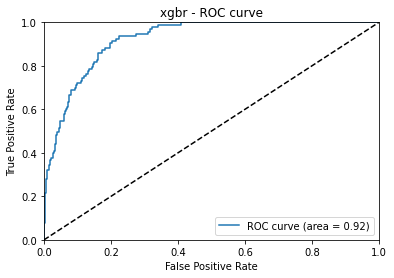

(63, 67)


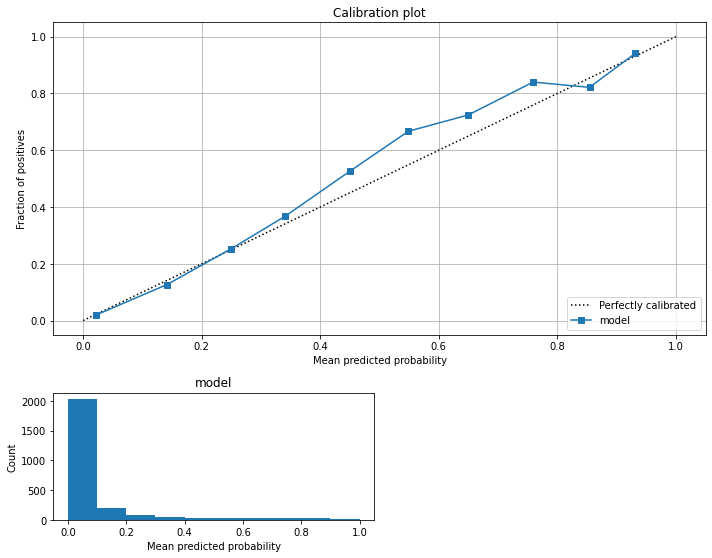

auc :  0.9235122044789719


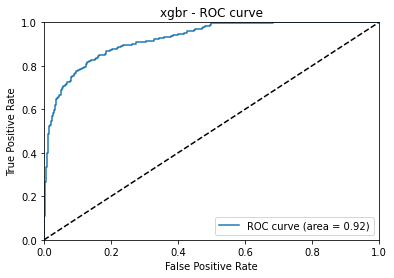

(67, 71)


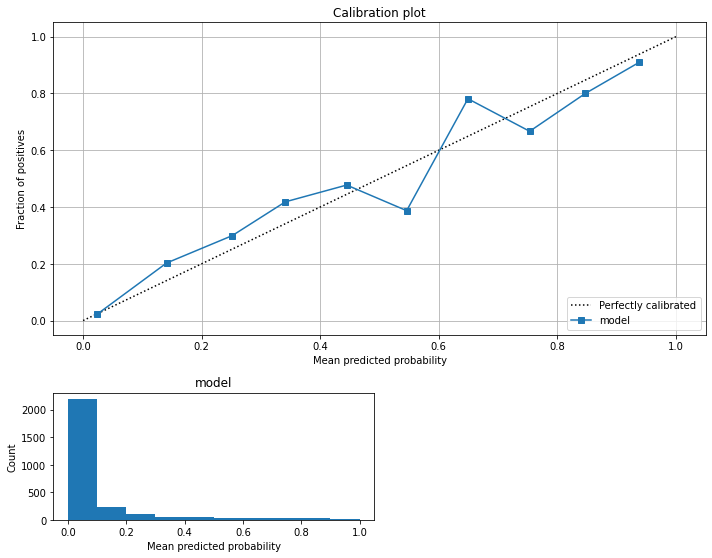

auc :  0.9185430976416219


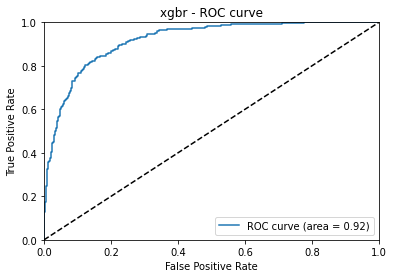

(71, 76)


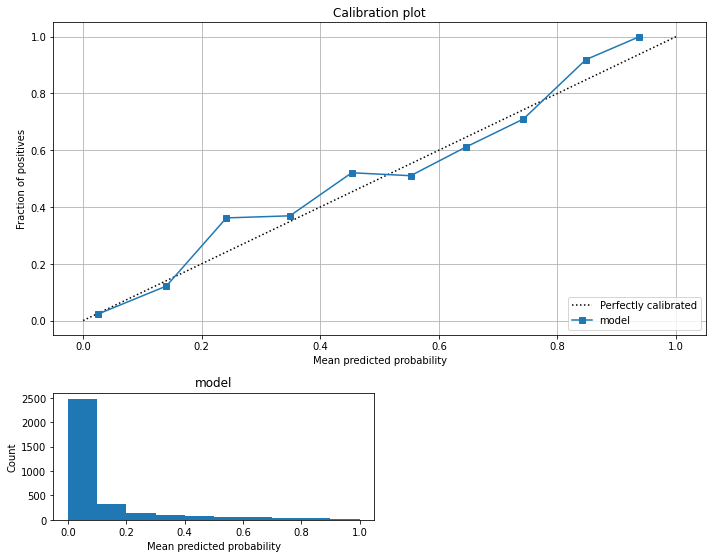

auc :  0.9202497942586049


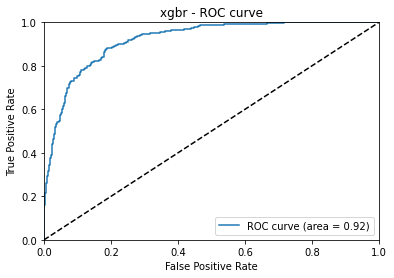

(76, 82)


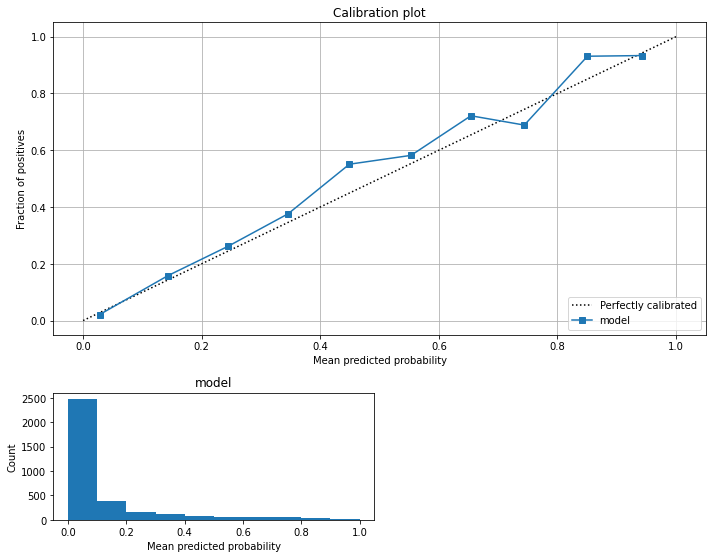

auc :  0.9152659974958091


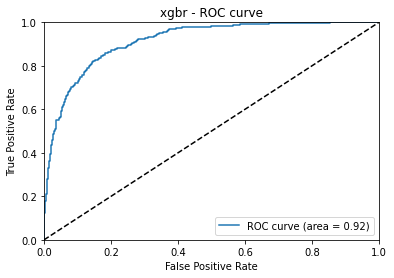

(82, 90)


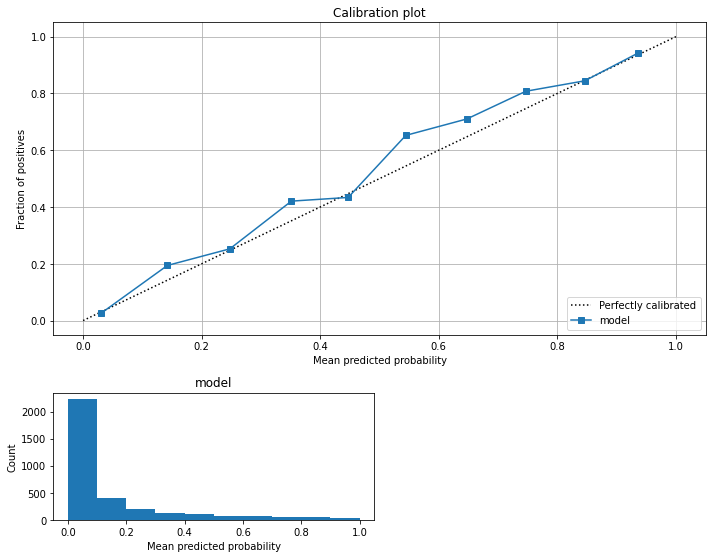

auc :  0.9016602850344537


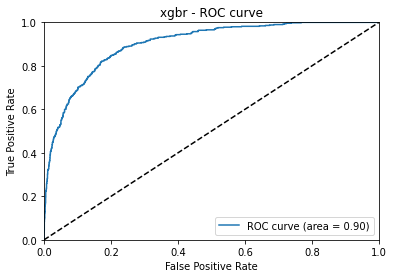

In [ ]:
# plot fairness of age protected variable

print(train_df["age"].quantile(np.linspace(.1, 1, 9, 0)))
ages = [(0,38), (38,50), (50,61), (61,63), (63,67), (67,71), (71,76), (76,82), (82,90)]
plot_death_distribution_by_subgroups(train_df, "age")
plot_subgroup_roc_calibration(ages, xtrain, xtest, ytest, xgbr_model,xtrain.columns, "age")

0.1     19.0
0.2     35.0
0.3     60.0
0.4     81.0
0.5    109.0
0.6    128.0
0.7    157.0
0.8    176.0
0.9    188.0
Name: hospital_id, dtype: float64


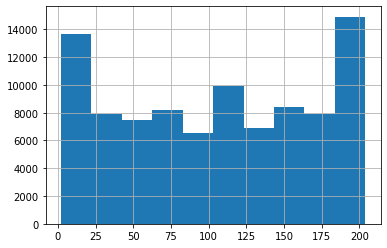

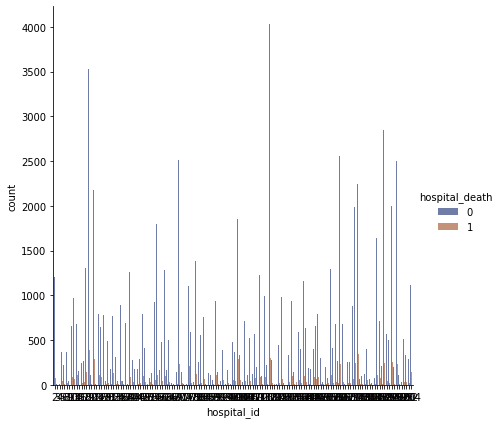

(0, 19)


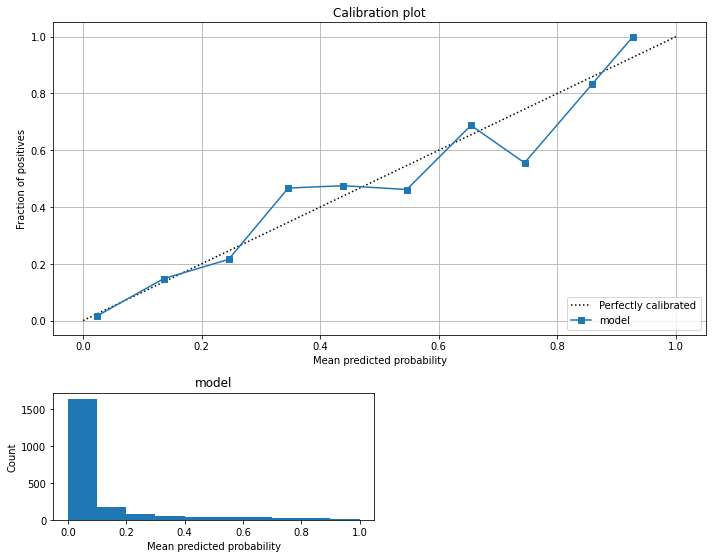

auc :  0.9244792473557456


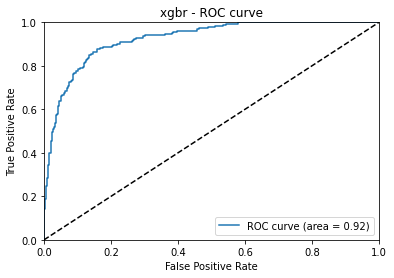

(19, 32)


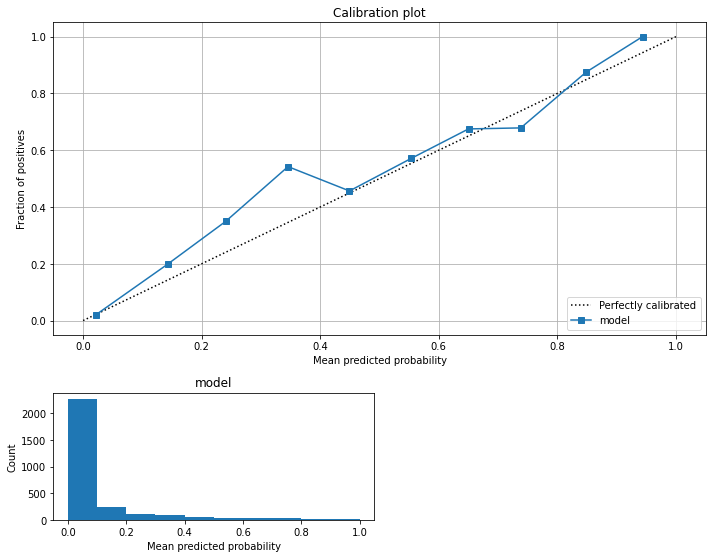

auc :  0.9267957601580611


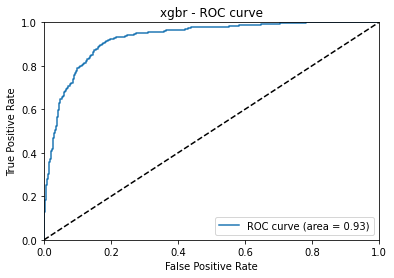

(32, 55)


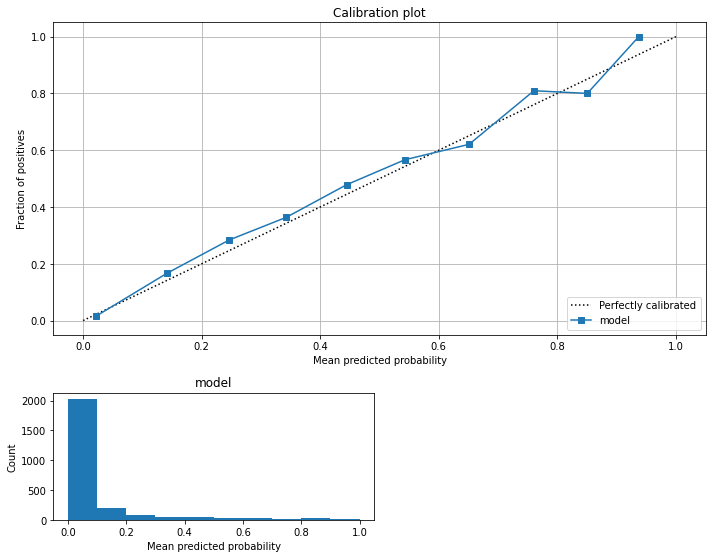

auc :  0.933424999471157


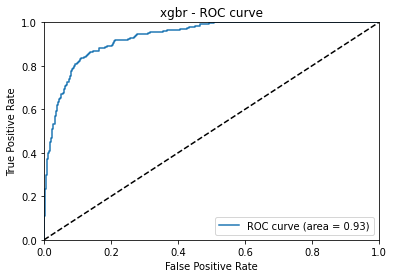

(55, 83)


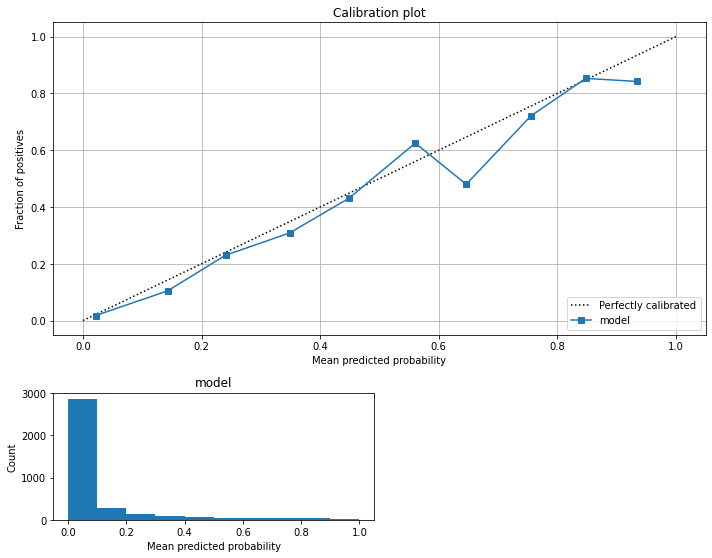

auc :  0.9221663838665941


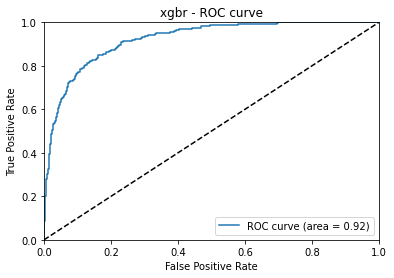

(83, 112)


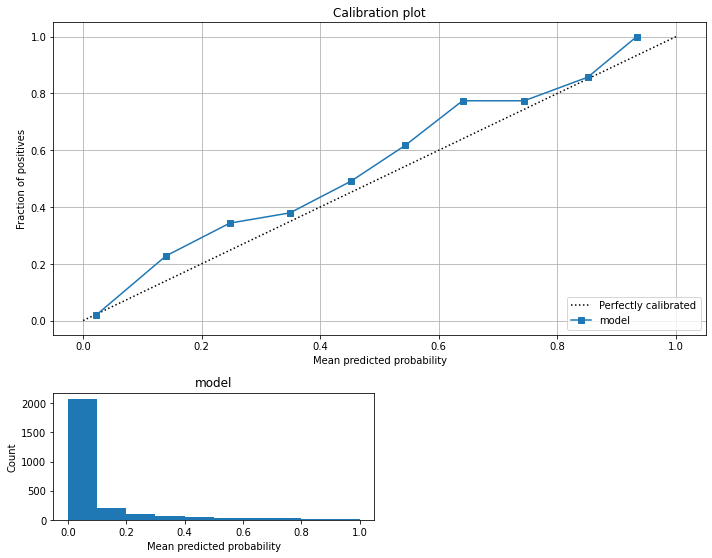

auc :  0.9330398408752506


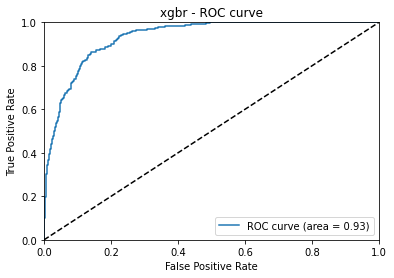

(112, 133)


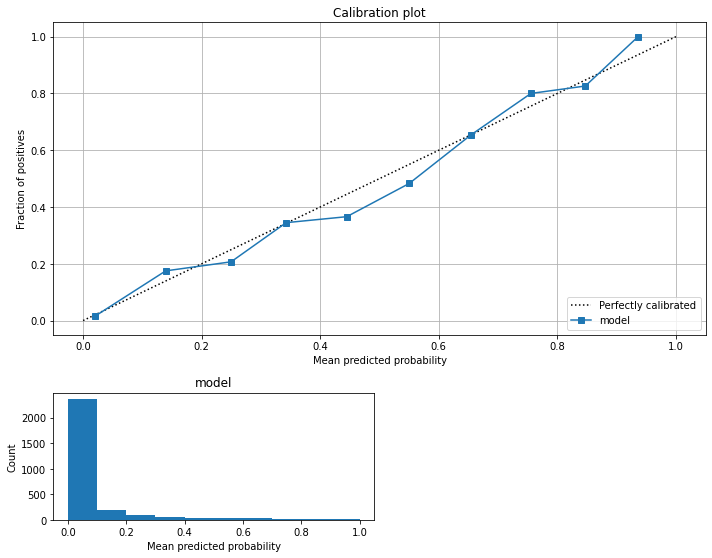

auc :  0.9292094417384789


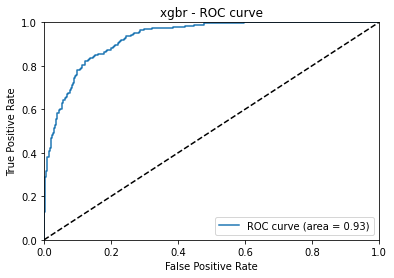

(133, 160)


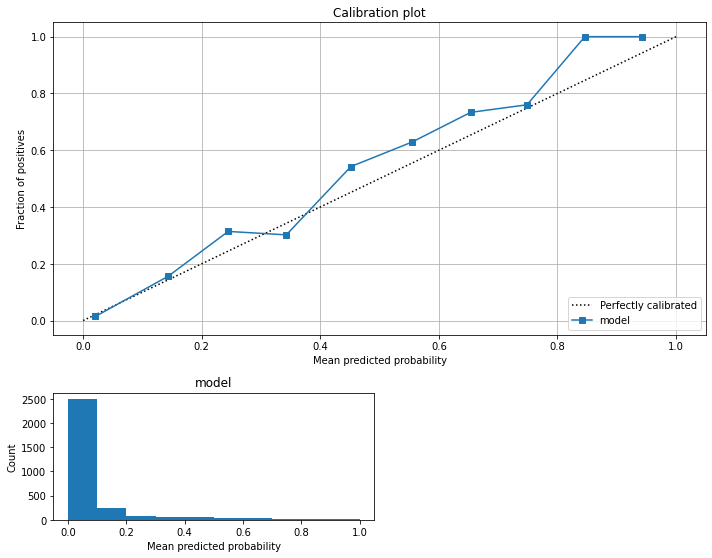

auc :  0.9438260044969017


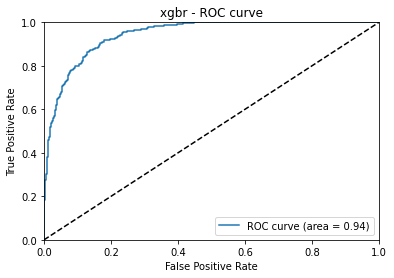

(160, 176)


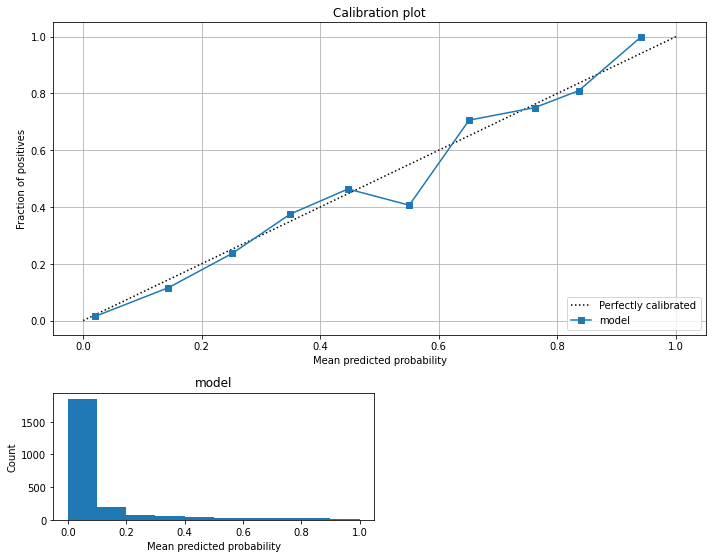

auc :  0.9336552942539389


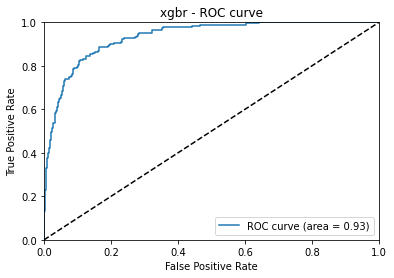

(176, 192)


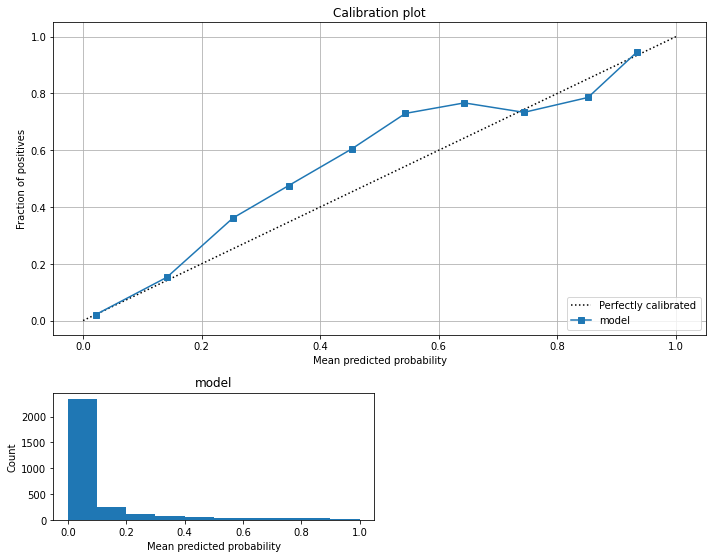

auc :  0.933045414145246


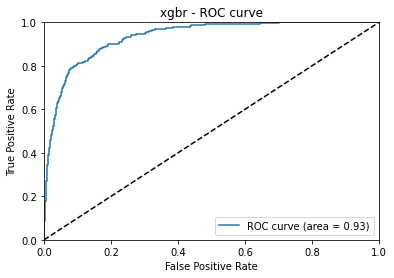

mean and std of cross validation score:  0.9280207732235481 0.0028629891385348197


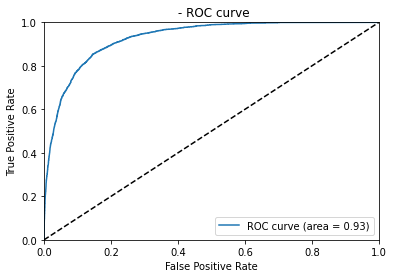

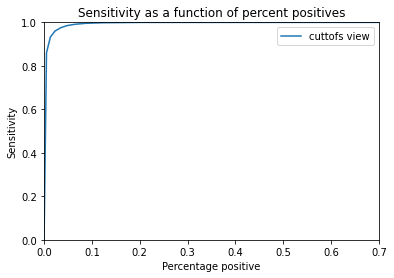

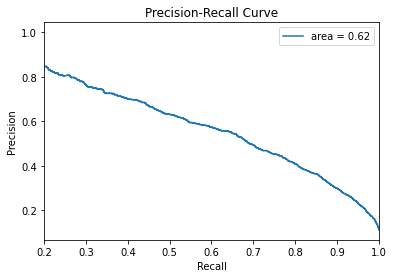

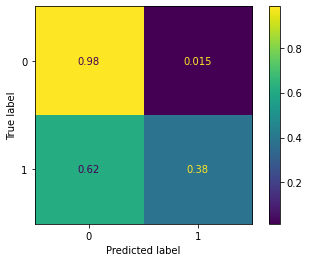

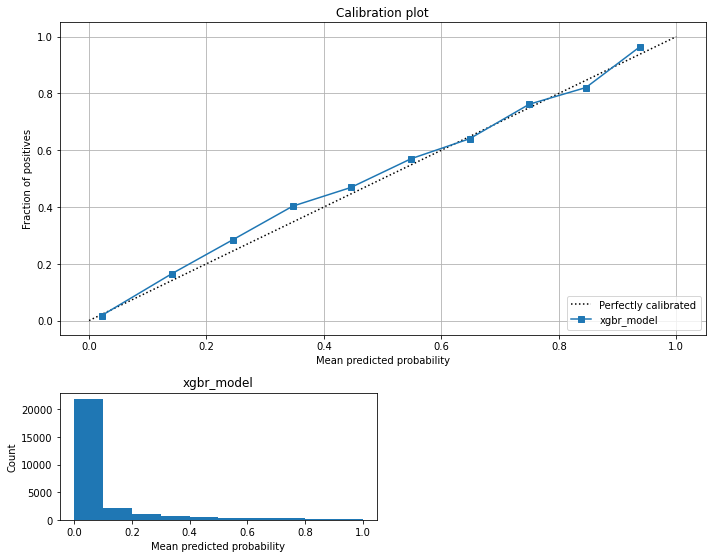

(0, 19)


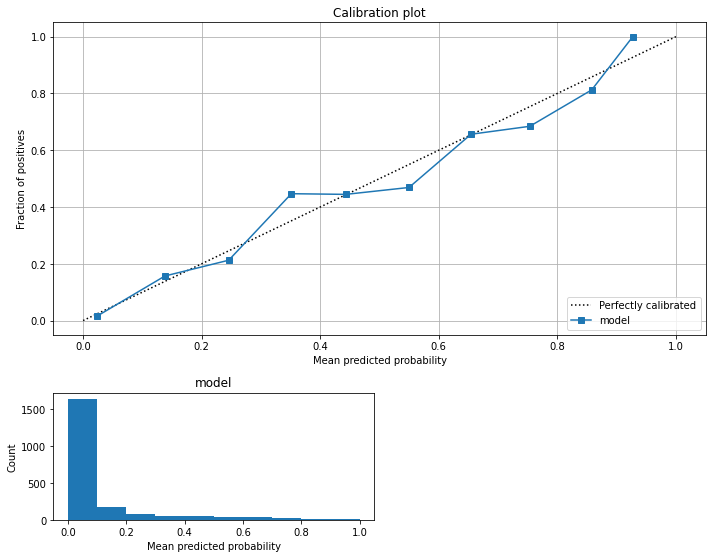

auc :  0.9237947692351028


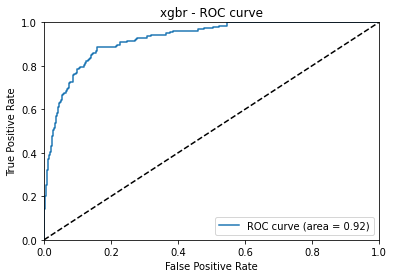

(19, 32)


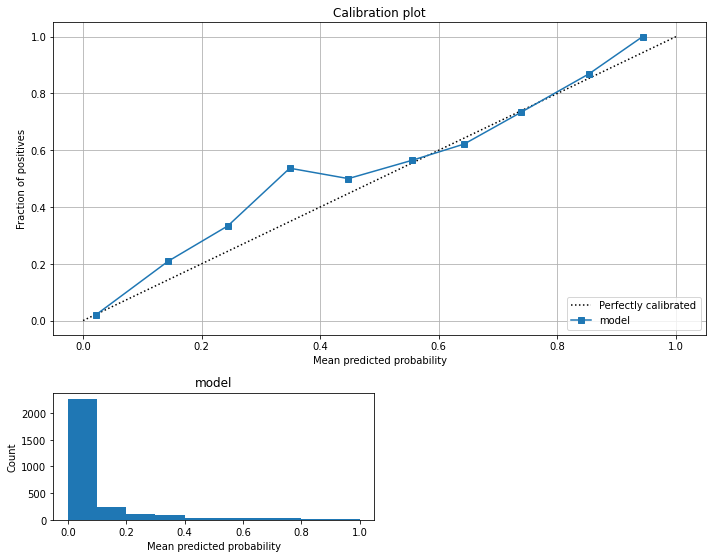

auc :  0.9268928869929276


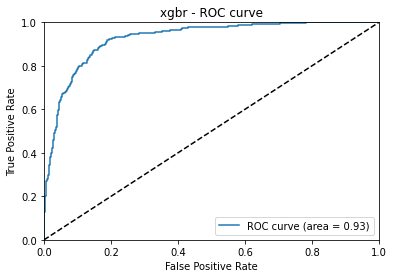

(32, 55)


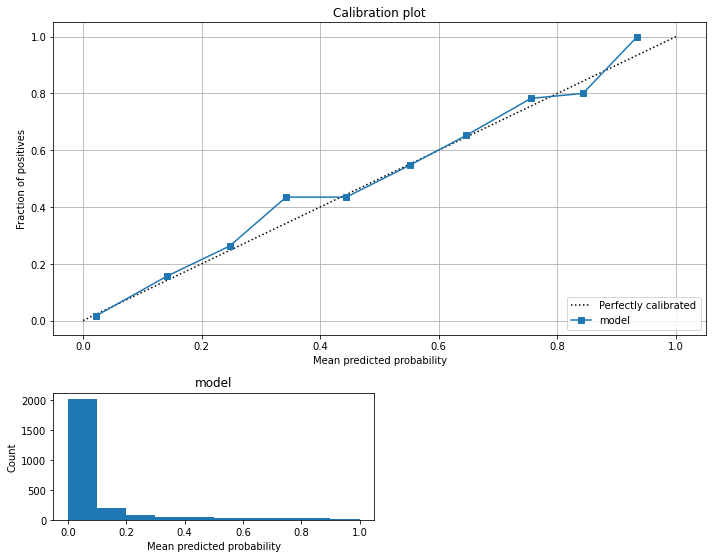

auc :  0.9330548092991771


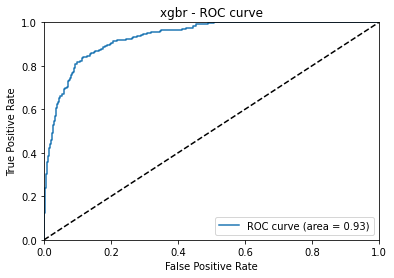

(55, 83)


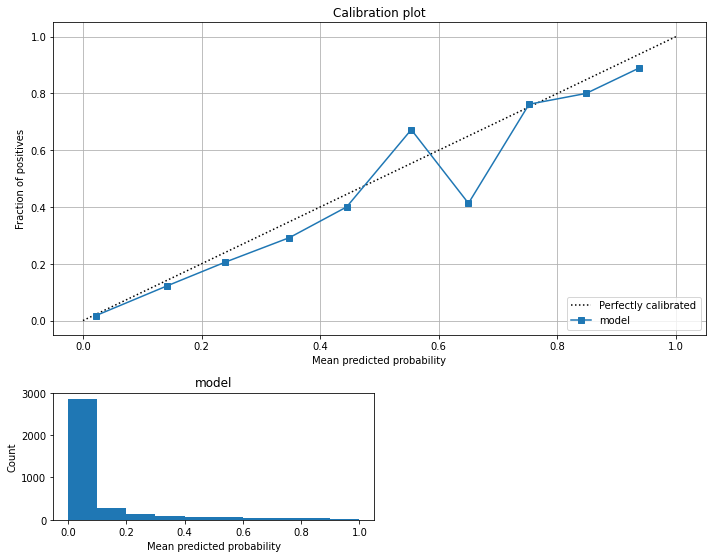

auc :  0.9223561575994739


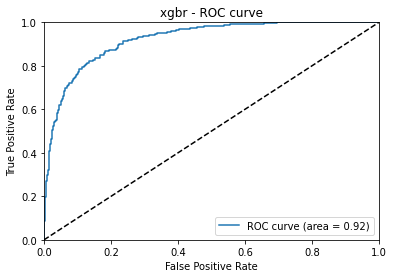

(83, 112)


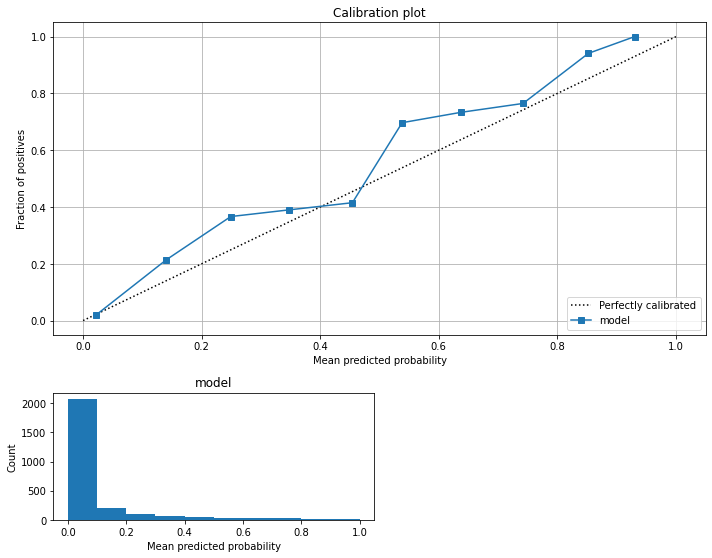

auc :  0.933160829887835


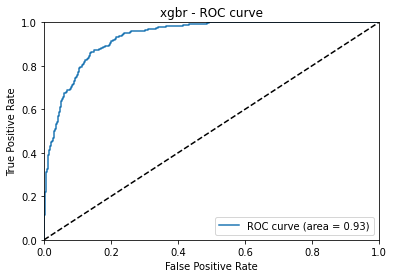

(112, 133)


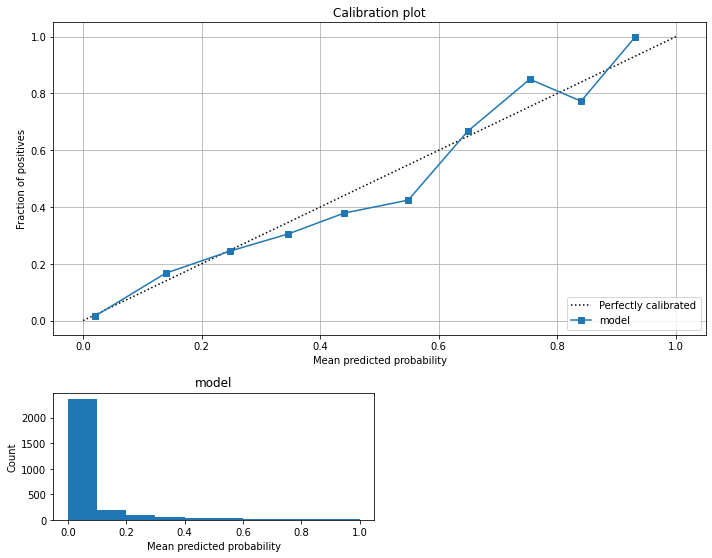

auc :  0.9292600224803296


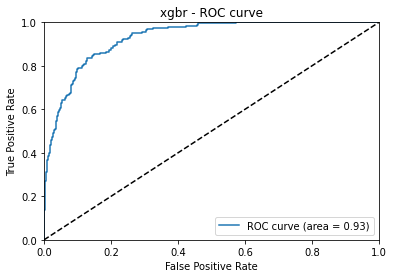

(133, 160)


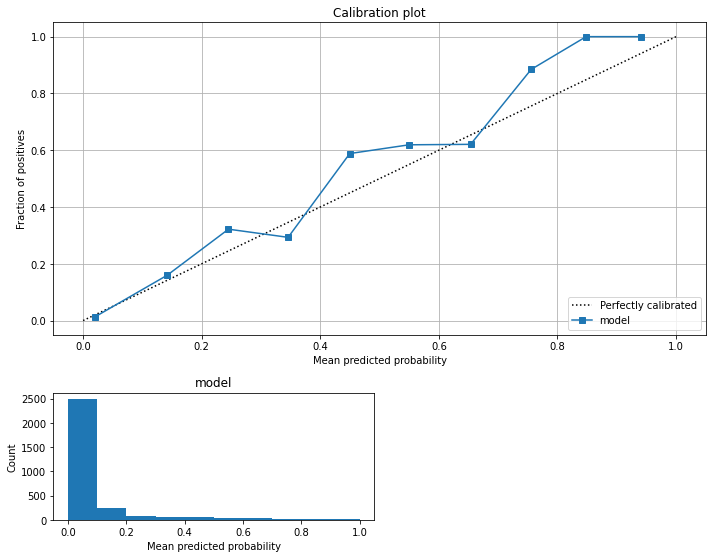

auc :  0.9436411186192009


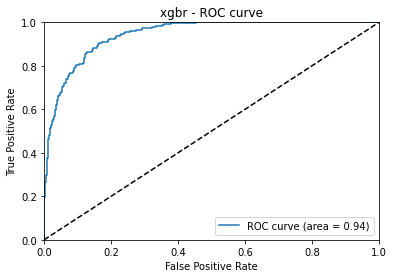

(160, 176)


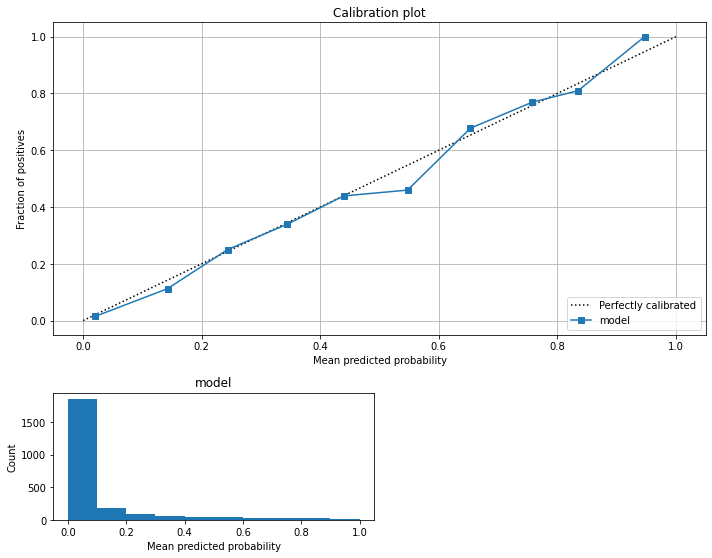

auc :  0.9332812017299968


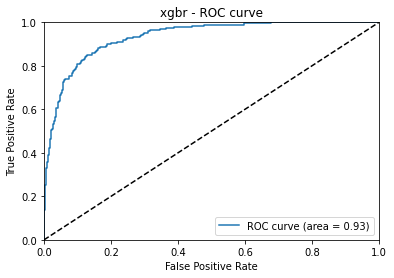

(176, 192)


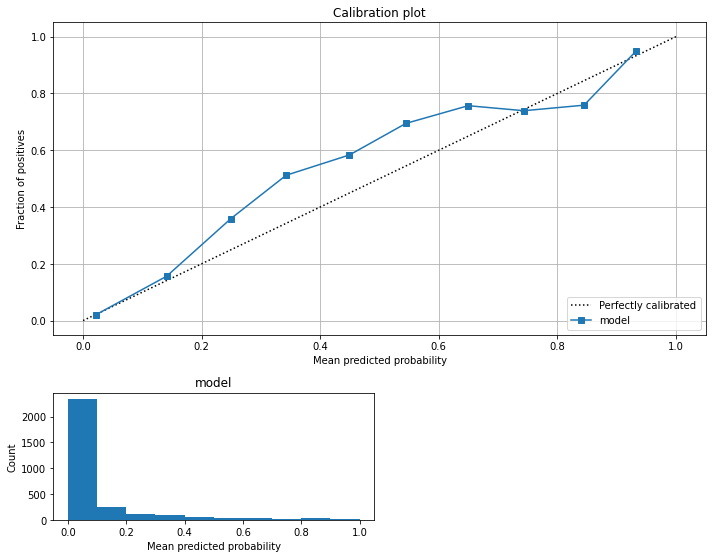

auc :  0.9329286901500755


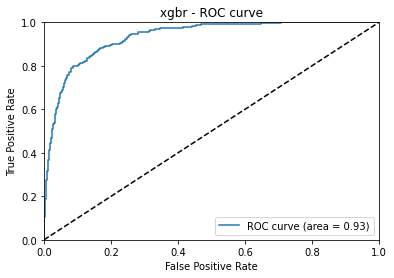

In [ ]:
# plot fairness of hospital_id protected variable

print(train_df["hospital_id"].quantile(np.linspace(.1, 1, 9, 0)))
hospital_ids = [(0,19), (19,32), (32,55), (55,83), (83,112), (112,133), (133,160), (160,176), (176,192)]
plot_death_distribution_by_subgroups(train_df, "hospital_id")
plot_subgroup_roc_calibration(hospital_ids, xtrain, xtest, ytest, xgbr_model, group_name="hospital_id")

# train xbg model withput the hospital_id protected variable
no_hospital_id = xtrain[xtrain.columns.difference(["hospital_id"])]
no_hospital_id_model = fit_eval_xbg_model(no_hospital_id, ytrain,xtest[no_hospital_id.columns], ytest, weights=True)
# plot again subethnicities ROC and calibration
plot_subgroup_roc_calibration(hospital_ids, xtrain, xtest, ytest, no_hospital_id_model,columns=no_hospital_id.columns, group_name="hospital_id")